In [2]:
# %matplotlib widget
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [4]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas
import experiments.fitting as fitter

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported experiments.

### Set save data

In [5]:
save_data = True

In [6]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [7]:
expt_path=os.path.join(os.getcwd(), 'data', 'data_240218')
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_240218


In [8]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


### Load config

In [73]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [10]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

# print(list(im))
# print(im)

In [11]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 15.0


In [12]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

# soc = QickConfig(im['Qick187'].get_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.207
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC ti

# Qubit/resonator to probe

In [13]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [74]:
qubit_i = 1
results_Qi = all_results[qubit_i]

# RFSoC Calibration

In [93]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=1.0, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i]-15, # [MHz]
    reps=1000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

215 307
readout freq 950 +/- 809.3487139155917


  0%|          | 0/1000 [00:00<?, ?it/s]

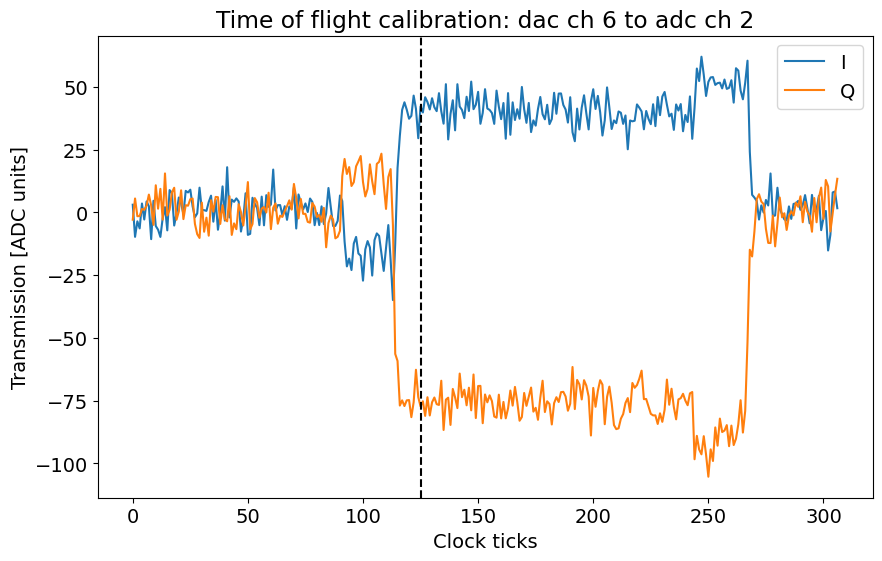

In [94]:
tof.display(adc_trig_offset=125)

# Initial single tone resonator spectroscopy

In [823]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 2.0 # MHz
npts = 250
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=2000,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec.cfg.device.readout.gain[qubit_i] = 0.10
rspec.cfg.device.readout.relax_delay = 25 # Wait time between experiments [us] - should be 5x resonator lifetime for good shape

import Pyro4.util
try:
    rspec.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/250 [00:00<?, ?it/s]

electrical delay phase correction (no mux support) (deg) 6.820692307004041
[93.52199999666671, 5000, 1000, 0, 17.061396149557044, 22.52277825099844, -4.096574636863515]
[ 9.34828057e+01  4.79807011e+02  1.15262921e+04  6.25797157e-01
  3.12163363e+02  1.17155673e+01 -2.85928893e+00]
lo freq 5925.0
mux mixer 950
fit resonator freq 93.48280567526845

Freq with minimum transmission: 93.51799999666672
Freq with maximum transmission: 92.54999999666671
From fit:
	f0: 6968.4828056752685
	Qi: 479.8070110035154
	Qe: 11526.292122222143
	Q0: 460.63219283372104
	kappa [MHz]: 15.128084649938375
	phi [radians]: 0.625797156569393


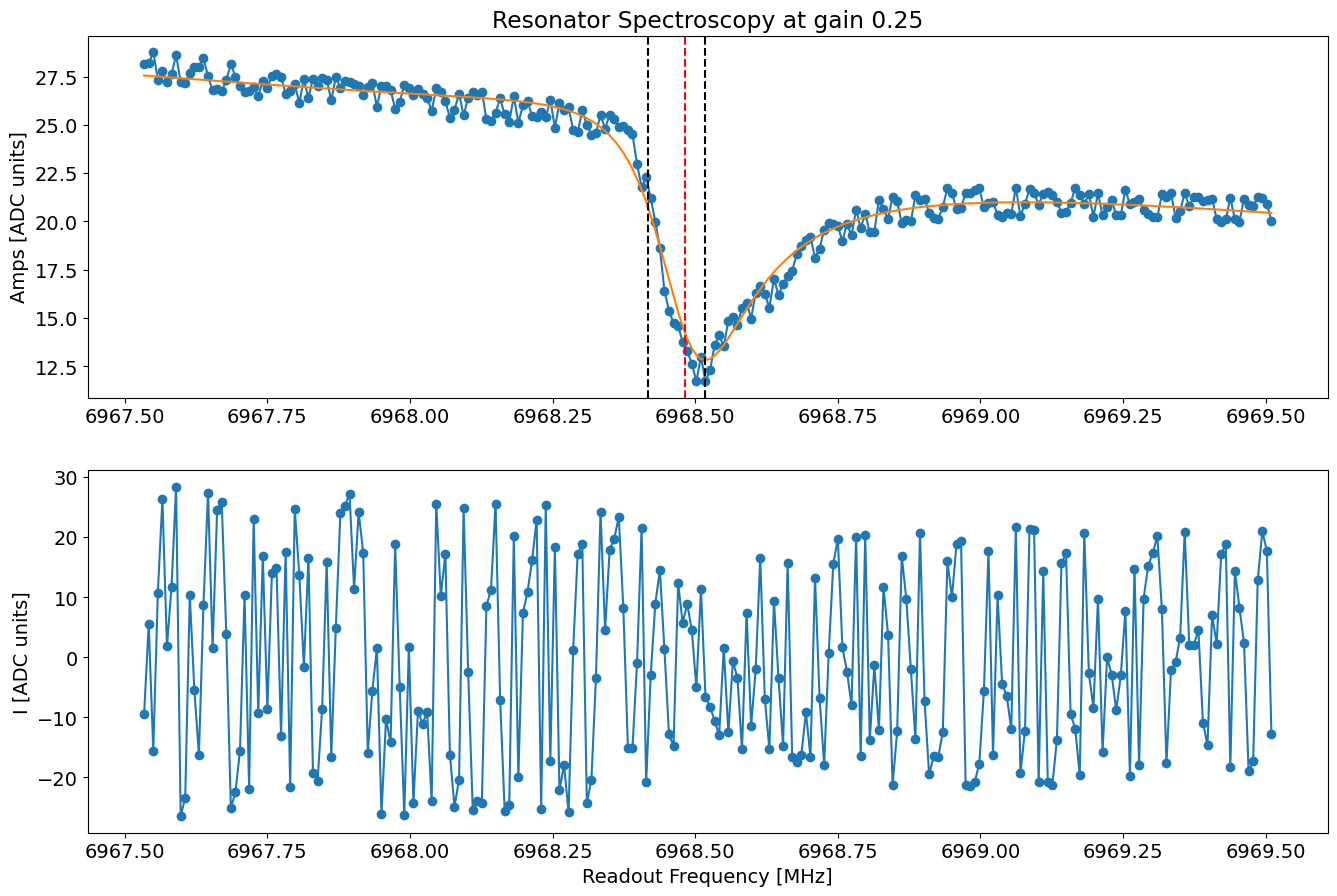

*Set cfg res 3 freq to 93.51799999666672*
*Set cfg res 3 gain to 0.25*
qubit 3 {'Res freq': 6968.517999996667, 'Res kappa': 0.20294457732139853}


In [824]:
# TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.data = rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]

res_freq_g = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
yaml_cfg.device.readout.frequency[qubit_i] = res_freq_g
# yaml_cfg.device.readout.frequency[qubit_i] = rspec.data['xpts'][np.argmax(rspec.data['amps'])]

yaml_cfg.device.readout.gain[qubit_i] = rspec.cfg.device.readout.gain[qubit_i]
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
print(f'*Set cfg res {qubit_i} gain to {yaml_cfg.device.readout.gain[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq)})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(f'qubit {qubit_i}', results_Qi)

In [360]:
if save_data: saved_files.append(rspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00000_resonator_spectroscopy_qubit3.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

In [825]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 300

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/10), # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4381.0674582561305, HWHM -0.6956037684202261
Found peak in I at [MHz] 4380.930506327529, HWHM 1.1744561673309142
Found peak in Q at [MHz] 4381.067340098063, HWHM -0.6992411851324029


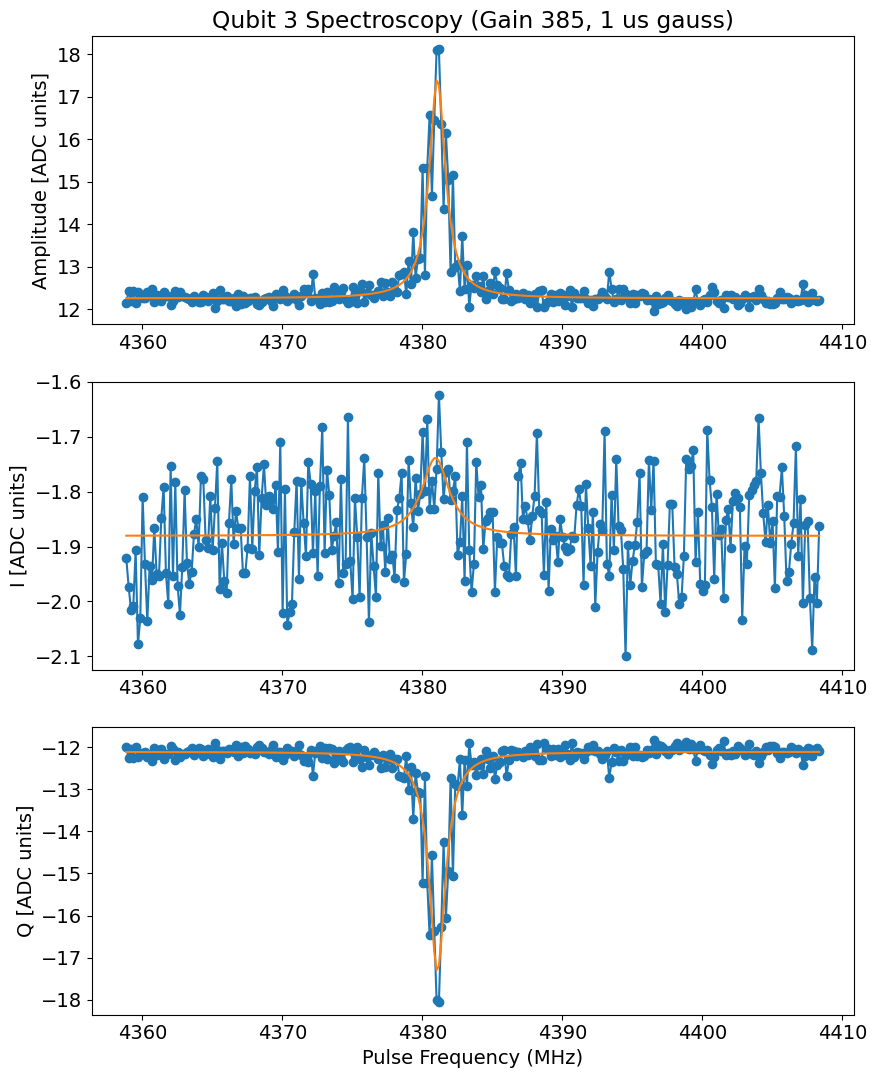

*Set qubit 3 f_ge to 4381.067340098063*
{'Res freq': 6968.517999996667, 'Res kappa': 0.20294457732139853, 'Qubit freq': 4381.067340098063}


In [826]:
# # TESTING
# # qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qspec.data['fit_err_avgi'][2][2]
        fit_err_q = qspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec.analyze(fit=True, signs=best_signs)
qspec.display(fit=True, signs=best_signs)

qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec_fit[2]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(results_Qi)

In [363]:
if save_data: saved_files.append(qspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00000_qubit_spectroscopy_qubit3.h5


## Pulse Probe (qubit) spectroscopy round 2

In [827]:
qspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 10
npts = 350

qspec2.cfg.expt = dict(
    start=qspec2.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=0.2, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/20), # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qspec2.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4381.0437192113595, HWHM 1.1503582611741383
Found peak in I at [MHz] 4380.912610440301, HWHM 1.0663680288450592
Found peak in Q at [MHz] 4381.043190184774, HWHM 1.1519393358457877


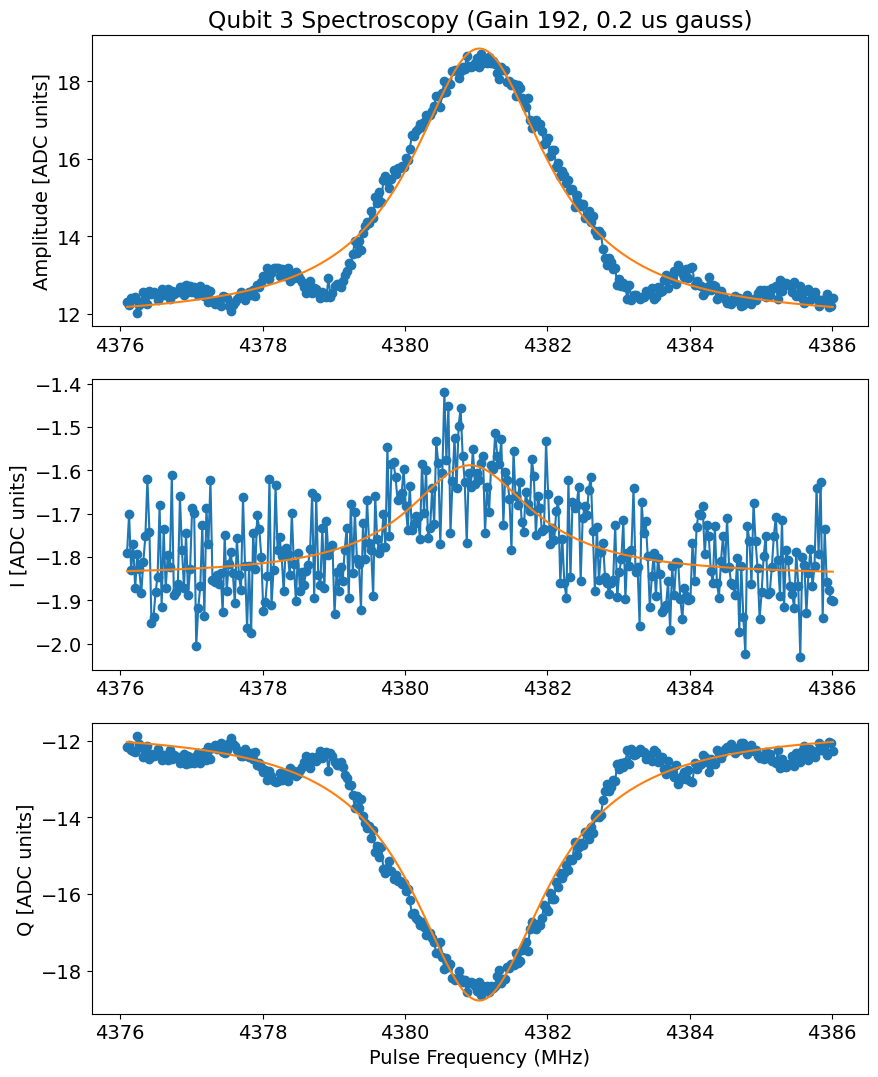

*Set qubit 3 f_ge to 4381.0437192113595*
{'Res freq': 6968.517999996667, 'Res kappa': 0.20294457732139853, 'Qubit freq': 4381.0437192113595}


In [828]:
# # TESTING
# # qspec2 = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec2.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec2.analyze(fit=True, signs=[1, sign, sign])
        fit_err_amps = qspec2.data['fit_err_amps'][2][2]
        fit_err_i = qspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec2.analyze(fit=True, signs=best_signs)
qspec2.display(fit=True, signs=best_signs)

qspec2_fit, qspec2_fit_err = meas.fitting.get_best_fit(qspec2.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec2_fit[2]
qubit_hwhm = qspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(results_Qi)

In [366]:
if save_data: saved_files.append(qspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00001_qubit_spectroscopy_qubit3.h5


## Length Rabi

In [164]:
# lengthrabi = meas.LengthRabiExperiment(
#     soccfg=soc,
#     path=expt_path,
#     prefix=f"length_rabi_qubit{qubit_i}",
#     config_file=config_path,
# )
# lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))

# lengthrabi.cfg.expt = dict(
#     start=0, # pulse length (sigma) [us]
#     step=soc.cycles2us(1), # [us]
#     # step=0.001,
#     expts=121,
#     reps=2000,
#     gain=yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i], # qubit gain [DAC units],
#     # gain=32000, # qubit gain [DAC units],
#     pulse_type='gauss',
#     checkZZ=False,
#     checkEF=False, 
#     qubits=[qubit_i],
# )
# # lengthrabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

# import Pyro4.util
# try:
#     lengthrabi.go(analyze=False, display=False, progress=True, save=False)
# except Exception:
#     print("Pyro traceback:")
#     print("".join(Pyro4.util.getPyroTraceback()))

In [165]:
# # # TESTING
# # # lengthrabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# # temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# # lengthrabi.data = temp_data

# lengthrabi.analyze(fit=True)

# lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabi.data) #, fitfunc=fitter.decaysin)

# lengthrabi.display(fit=True)
# p = lengthrabi_fit
# if p[2] > 180: p[2] = p[2] - 360
# elif p[2] < -180: p[2] = p[2] + 360
# if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
# else: pi_len = (3/2 - p[2]/180)/2/p[1]
# pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

# lengthrabi_decay = p[3]

# print(f'Will use sigma {pi_len} for amplitude rabi')

In [166]:
# if save_data: saved_files.append(lengthrabi.save_data())

## Amplitude Rabi

In [829]:
pi_len = yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]
# pi_len = 0.020
print('qubit', qubit_i, 'pi_len', pi_len)

qubit 3 pi_len 0.01


In [830]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i])))
npts = 151
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    # reps=5,
    rounds=10,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
amprabi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

0.00017543859649122806
Pi gain from amps data [dac units]: 3831
	Pi/2 gain from amps data [dac units]: 1915
Pi gain from avgi data [dac units]: 6887
	Pi/2 gain from avgi data [dac units]: 3443
Pi gain from avgq data [dac units]: 3831
	Pi/2 gain from avgq data [dac units]: 1915


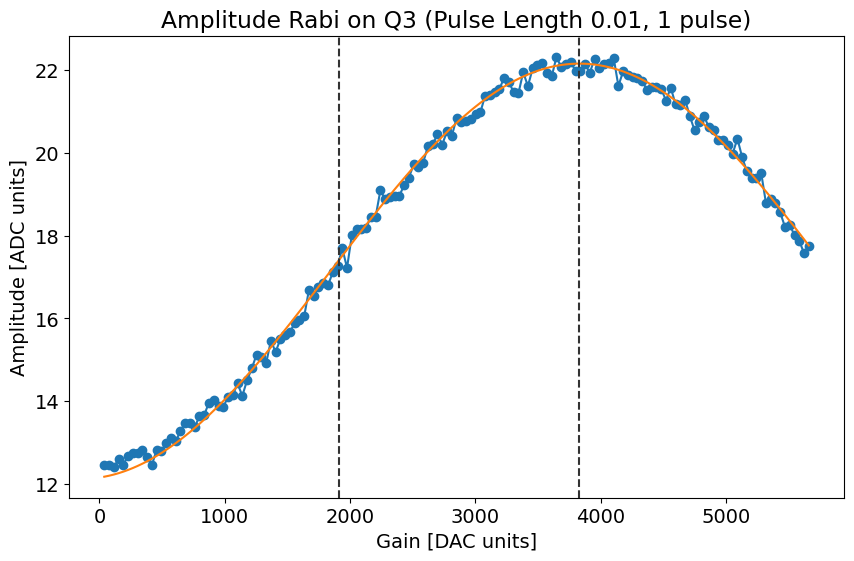

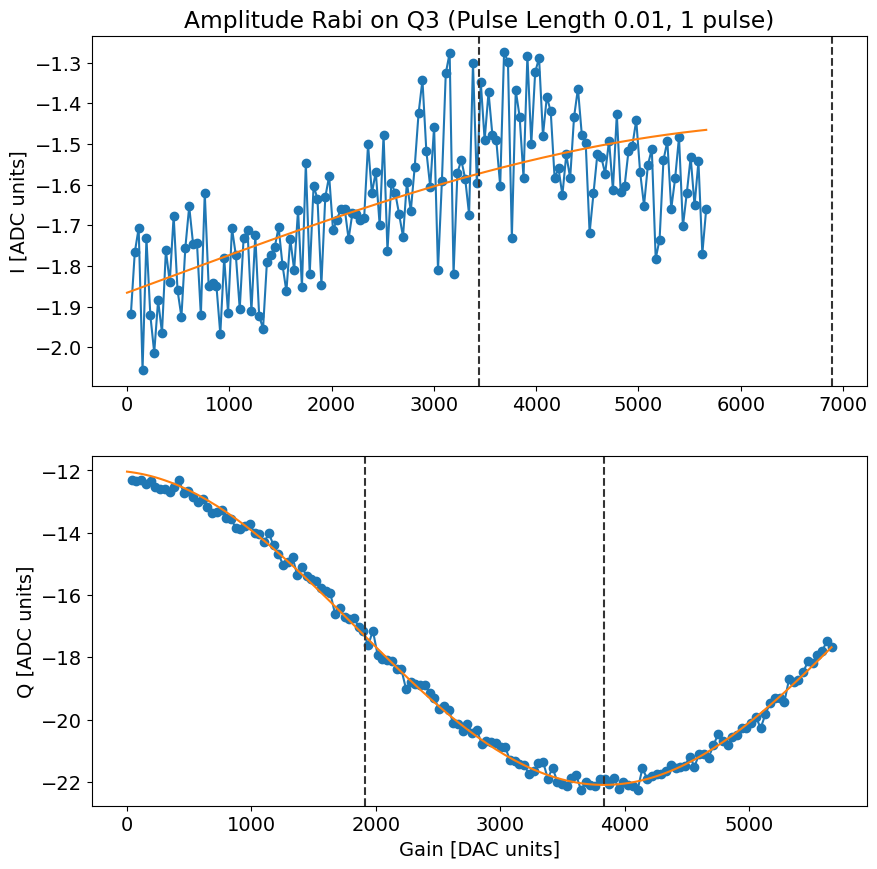

*Set pi pulse sigma for qubit 3 to 0.01*
*Set pi pulse gain for qubit 3 to 3831*
{'Res freq': 6968.517999996667, 'Res kappa': 0.20294457732139853, 'Qubit freq': 4381.0437192113595, 'Pi pulse len': 0.01, 'Pi pulse gain': 3831}


In [831]:
# # TESTING
# # amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi.data = temp_data

amprabi.analyze(fit=True)

amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

p = amprabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi.display(fit=False)
    print(f'WARNING: Fit pi pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse len':yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]})
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(results_Qi)

In [544]:
if save_data: saved_files.append(amprabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00004_amp_rabi_qubit1.h5


## $T_1$

In [832]:
# if lengthrabi_decay < 10: short_T1 = True
# else: short_T1 = False
short_T1 = False

In [833]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)
t1.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50 if short_T1 else 400
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    # reps=5,
    rounds=20,
    qubit=qubit_i,
)
t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]
t1.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Fit T1 avgi [us]: 50.53666141657476
Fit T1 avgq [us]: 51.26303063231619


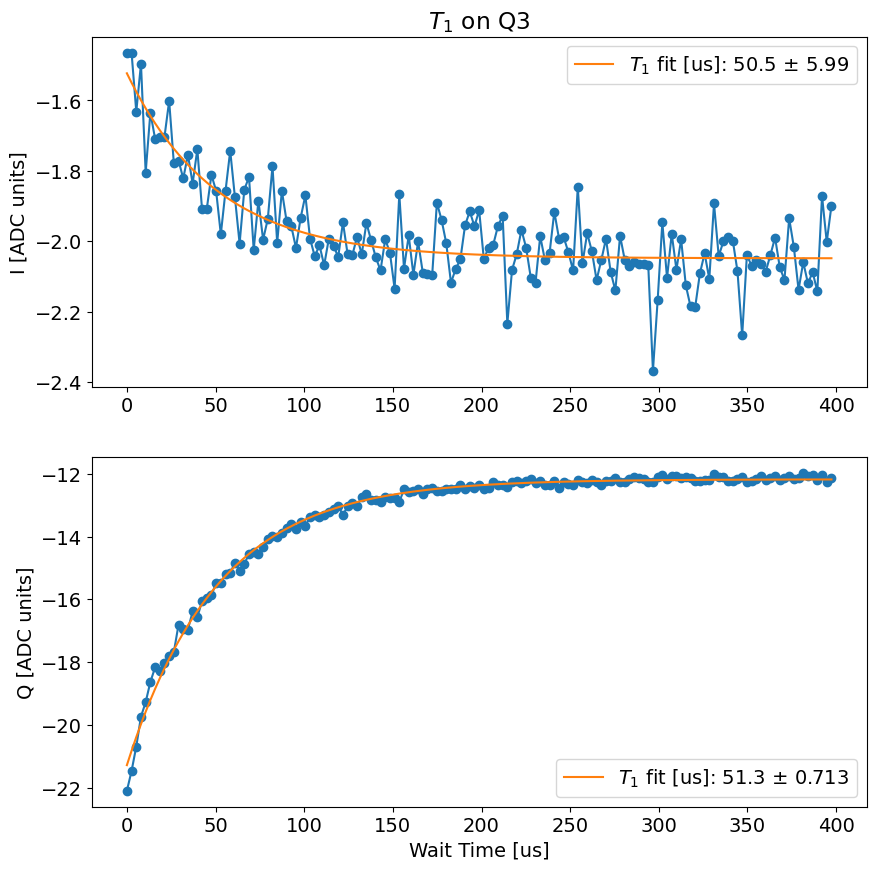

*Set qubit 3 T1 to 51.0*
*Set readout 3 relax delay to 205.0*
qubit 3 {'Res freq': 6968.517999996667, 'Res kappa': 0.20294457732139853, 'Qubit freq': 4381.0437192113595, 'Pi pulse len': 0.01, 'Pi pulse gain': 3831, 'T1': 51.26303063231619, 'T1 err': 0.713440011513084}


In [834]:
# # TESTING
# # t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# t1.data = temp_data

t1.analyze(fit_log=False)

t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data) #, fitter.expfunc)

t1.display(fit=True, fit_log=False)
yaml_cfg.device.qubit.T1[qubit_i] = np.round(t1_fit[3])
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(4*t1_fit[3])
print(f'*Set qubit {qubit_i} T1 to {yaml_cfg.device.qubit.T1[qubit_i]}*')
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1':t1_fit[3], 'T1 err':np.sqrt(t1_fit_err[3][3])})
print(f'qubit {qubit_i}', results_Qi)

In [643]:
if save_data: saved_files.append(t1.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00002_t1_qubit2.h5


## $T_2$ Ramsey round 1

In [15]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubit_hwhm = 2
short_T1 = False
short_T1 = yaml_cfg.device.qubit.T1[qubit_i] < 20
print('Short T1', short_T1)

Short T1 False


In [16]:
# ramsey_freq = max((min((np.abs(np.ceil(qubit_hwhm)), 3)), 2))
ramsey_freq = 3.0
print(f'Ramsey freq [MHz]: {ramsey_freq}')

Ramsey freq [MHz]: 3.0


In [75]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(1) if short_T1 else soc.cycles2us(8), # [us] 
    # step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=200,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=100,
    rounds=10,
    qubits=[qubit_i],
    checkZZ=False,
    checkEF=False,
)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

readout freq [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671]


  0%|          | 0/10 [00:00<?, ?it/s]

p_amps [ 4.88673721  3.01361038 86.81378308 36.27120502 45.44816156]
0
ps amps 45.4481615641478 4.886737212707771 36.27120502477048
Current pi pulse frequency: 3450.456887958334
Fit frequency from amps [MHz]: 3.0136103820669775 +/- 0.0010428485911505156
Suggested new pi pulse frequencies from fit amps [MHz]:
 	-0.013610382066977511
 	-6.013610382066977
T2 Ramsey from fit amps [us]: 36.27120502477048
Current pi pulse frequency: 3450.456887958334
Fit frequency from I [MHz]: 3.0136180512684523 +/- 0.001495040980768736
Suggested new pi pulse frequency from fit I [MHz]:
 	3450.4432699070653
 	3444.4432699070653
T2 Ramsey from fit I [us]: 28.165046186658547
Fit frequency from Q [MHz]: 3.013653712823255 +/- 0.0012267365992011249
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3450.4432342455107
 	3444.4432342455107
T2 Ramsey from fit Q [us]: 49.60507463389019


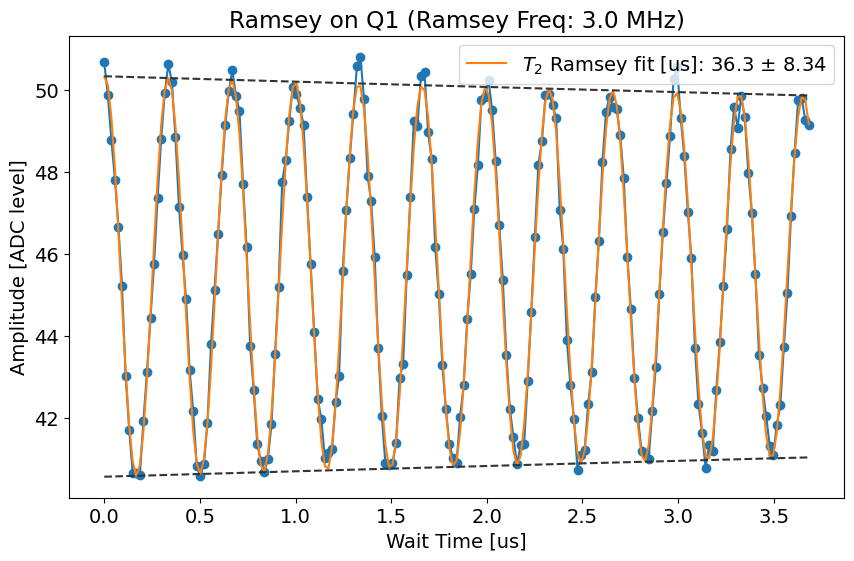

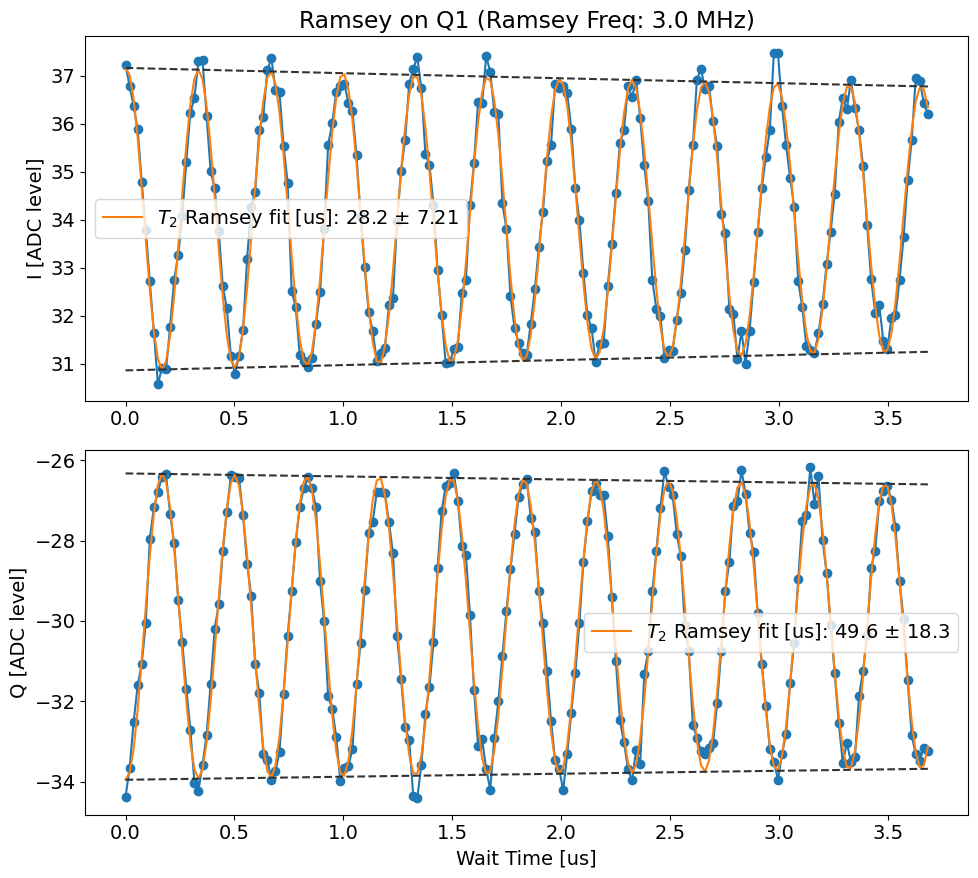

*Set qubit 1 freq to 3450.443277576267*
Alt qubit freq is 3444.443277576267


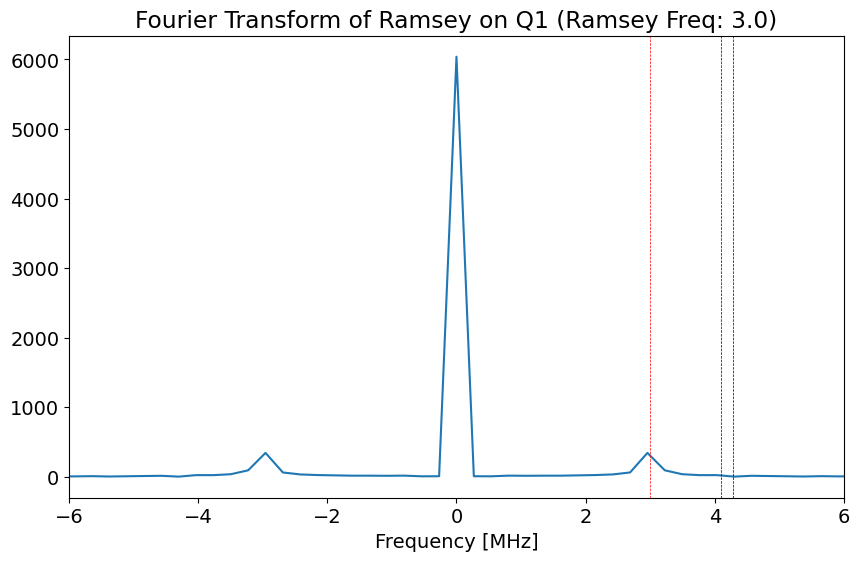

In [77]:
# # TESTING
# # t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.data = temp_data

# t2r.analyze(fit=True, fit_num_sin=2)
# t2r.display(fit=True, fit_num_sin=2)

t2r.analyze(fit=True)
t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

old_qubit_freq = t2r.cfg.device.qubit.f_ge[qubit_i]
t2r.display(fit=True)
yaml_cfg.device.qubit.f_ge[qubit_i] = old_qubit_freq + t2r_adjust[0]
alt_qubit_freq = old_qubit_freq + t2r_adjust[1]
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Alt qubit freq is {alt_qubit_freq}')

data = t2r.data
fit_axis = 'avgq'
xpts = data['xpts']
fourier = np.fft.fftshift(np.abs(np.fft.fft(data[fit_axis])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(xpts[1]-xpts[0])))
plt.plot(freqs, fourier)
ZZs = np.reshape(t2r.cfg.device.qubit.ZZs, (4, 4))
for i in range(4):
    if (qubit_i+i)%4 == qubit_i: color = 'r'
    else: color = 'k'
    plt.axvline(t2r.cfg.expt.ramsey_freq - ZZs[qubit_i, (qubit_i+i)%4], color=color, linewidth=0.5, linestyle='--')
plt.xlabel('Frequency [MHz]')
plt.xlim(-6, 6)
# plt.ylim(0, 20000)
plt.title(f'Fourier Transform of Ramsey on Q{qubit_i} (Ramsey Freq: {t2r.cfg.expt.ramsey_freq})')
plt.show()


In [469]:
if save_data: saved_files.append(t2r.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00002_ramsey_qubit1.h5


## Amplitude Rabi round 2

In [35]:
pi_len = yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]
print('qubit', qubit_i, 'pi_len', pi_len)
# pi_len = 0.010

qubit 0 pi_len 0.02


In [38]:
amprabi_2 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi_2.cfg = AttrDict(deepcopy(yaml_cfg))

n_pulses = 1
span = min((32000, int(1.5*(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/n_pulses))))
npts = 151
    
amprabi_2.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    # reps=5,
    rounds=20,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    n_pulses=n_pulses,
    qubits=[qubit_i],
)
amprabi_2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

3.284072249589491e-05
Pi gain from amps data [dac units]: 20504
	Pi/2 gain from amps data [dac units]: 10252
Pi gain from avgi data [dac units]: 20500
	Pi/2 gain from avgi data [dac units]: 10250
Pi gain from avgq data [dac units]: 20502
	Pi/2 gain from avgq data [dac units]: 10251


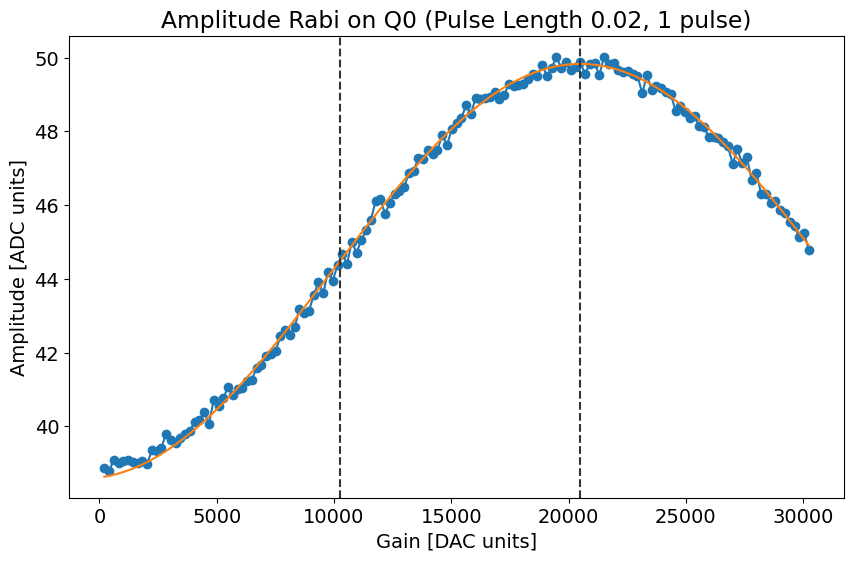

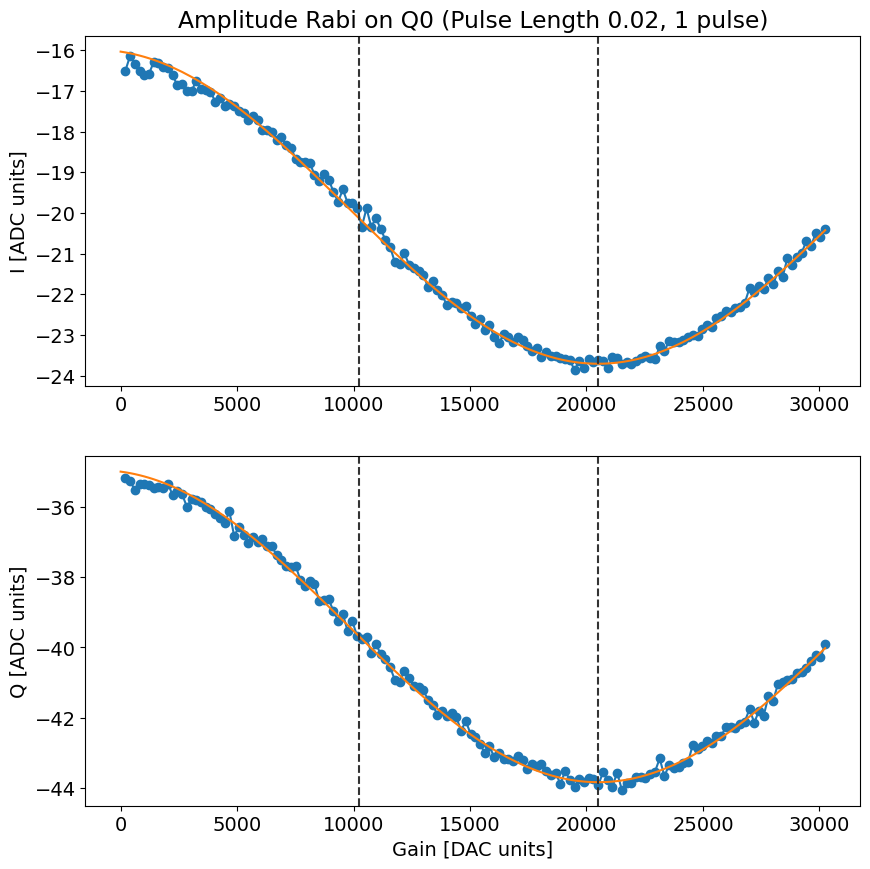

*Set pi pulse sigma for qubit 0 to 0.02*
*Set pi pulse gain for qubit 0 to 20504*
{'Single shot g-e fidelity (%)': 72.70181754543864, 'T2R': 50.57418606681376, 'T2R err': 1.2439021802872954, 'Qubit freq': 4116.62788350742, 'Pi pulse len': 0.02, 'Pi pulse gain': 20504}


In [39]:
# # TESTING
# # amprabi_2 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi_2.data = temp_data

amprabi_2.analyze(fit=True)

amprabi_2_fit, amprabi_2_fit_err = meas.fitting.get_best_fit(amprabi_2.data)

p = amprabi_2_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi_2.display(fit=False)
    print(f'WARNING: Fit pi pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi_2.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi_2.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(n_pulses*pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse len':yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]})
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(results_Qi)

In [473]:
if save_data: saved_files.append(amprabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00000_amp_rabi_qubit3.h5


## $T_2$ Ramsey round 2

Check that frequency adjustment helps.

In [33]:
t2r_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    # step=soc.cycles2us(2) if t2r_fit[3] < 3 else soc.cycles2us(60), # [us]
    # step=soc.cycles2us(80), # [us]
    step=soc.cycles2us(150), # [us]
    expts=151,
    ramsey_freq=ramsey_freq/15, # [MHz]
    # ramsey_freq=ramsey_freq/20, # [MHz]
    reps=100,
    rounds=20,
    checkZZ=False,
    checkEF=False,
    qubits=[qubit_i],
)
t2r_2.go(analyze=False, display=False, progress=True, save=False)

readout freq [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671]


  0%|          | 0/20 [00:00<?, ?it/s]

p_amps [4.945308595234508 0.2 11.540530482635626 51.967075892857146
 44.59578341664715]
ps amps 44.59578341664715 4.945308595234508 51.967075892857146
Current pi pulse frequency: 4116.60193514429
Fit frequency from amps [MHz]: 0.2 +/- inf
Suggested new pi pulse frequencies from fit amps [MHz]:
 	0.0
 	-0.4
T2 Ramsey from fit amps [us]: 51.967075892857146
Current pi pulse frequency: 4116.60193514429
Fit frequency from I [MHz]: 0.2 +/- inf
Suggested new pi pulse frequency from fit I [MHz]:
 	4116.60193514429
 	4116.2019351442905
T2 Ramsey from fit I [us]: 51.967075892857146
Fit frequency from Q [MHz]: 0.1740516368705289 +/- 8.017311876413337e-05
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4116.62788350742
 	4116.227883507419
T2 Ramsey from fit Q [us]: 50.57418606681376


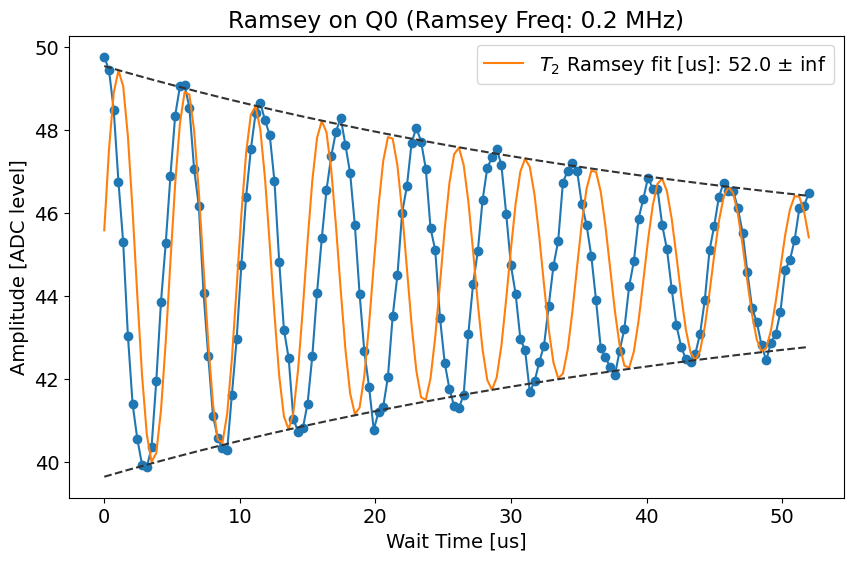

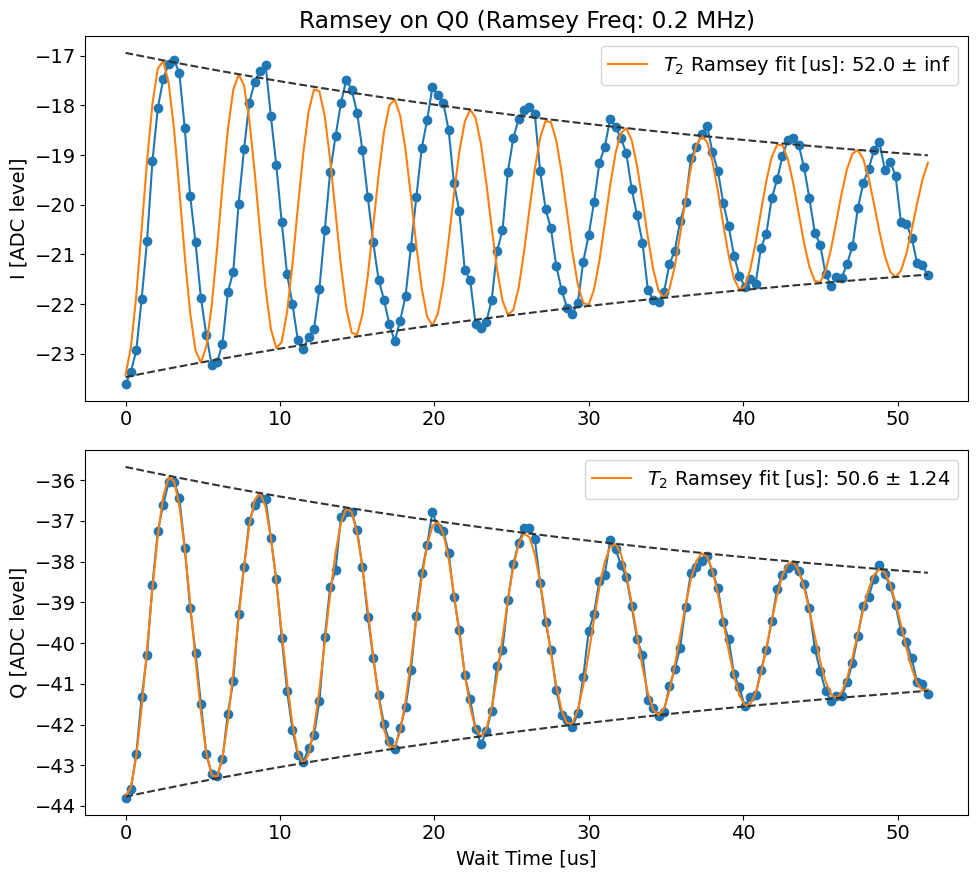

*Set qubit 0 freq to 4116.62788350742*
{'Single shot g-e fidelity (%)': 72.70181754543864, 'T2R': 50.57418606681376, 'T2R err': 1.2439021802872954, 'Qubit freq': 4116.62788350742}
Redo T2R: False


In [34]:
# # TESTING
# # t2r_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r_2.data = temp_data

redo_t2r = True

t2r_2.analyze(fit=True)

t2r_2_fit, t2r_2_fit_err, t2r_2_adjust = meas.fitting.get_best_fit(t2r_2.data, get_best_data_params=['f_adjust_ramsey'])

t2r_2.display(fit=True)
final_qubit_freq = t2r_2.cfg.device.qubit.f_ge[qubit_i] + t2r_2_adjust[0]
if abs(t2r_2_adjust[0]) <= ramsey_freq/10:
# if abs(t2r_2_adjust[0]) <= abs(t2r_adjust[0]):
    redo_t2r = False
    yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
    results_Qi.update({'T2R':t2r_2_fit[3], 'T2R err':np.sqrt(t2r_2_fit_err[3][3])})
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(results_Qi)
else: # redo_t2r = True
    yaml_cfg.device.qubit.f_ge[qubit_i] = alt_qubit_freq 
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Redo T2R: {redo_t2r}')

In [ ]:
if save_data: saved_files.append(t2r_2.save_data())

## GE error amplification

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671], 'frequency_ef': [-67.5604563688476, -818.3165832328616, 823.0647139155917, 92.22599999666672], 'gain': [0.16, 0.11, 0.4, 0.4], 'readout_length': [7.0, 5.0, 8.0, 2.5], 'relax_delay': [300, 525, 300, 350]}, 'qubit': {'f_ge': [4116.62788350742, 3450.456887958334, 4766.546959121259, 4381.241623620314], 'f_ef': [3890.5466932677664, 3349.983151894969, 4576.680453599131, 4210.642810651382], 'f_Q1_ZZ': [3445.1849181153643, 0, 3449.3659388054953, 3449.167602826072], 'f_Q_ZZ1': [4111.357154037054, 0, 4765.446645017305, 4379.754451085988], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5889.630708333333, 5145.8], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [53.81744103399963, 55.95274071800953, 44.5514225071792, 4.324246873301848, 2.3034231276846207, 6.286079155406997], 'ZZs': [0.0, -5.244781107236122, -0.1301

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (3)


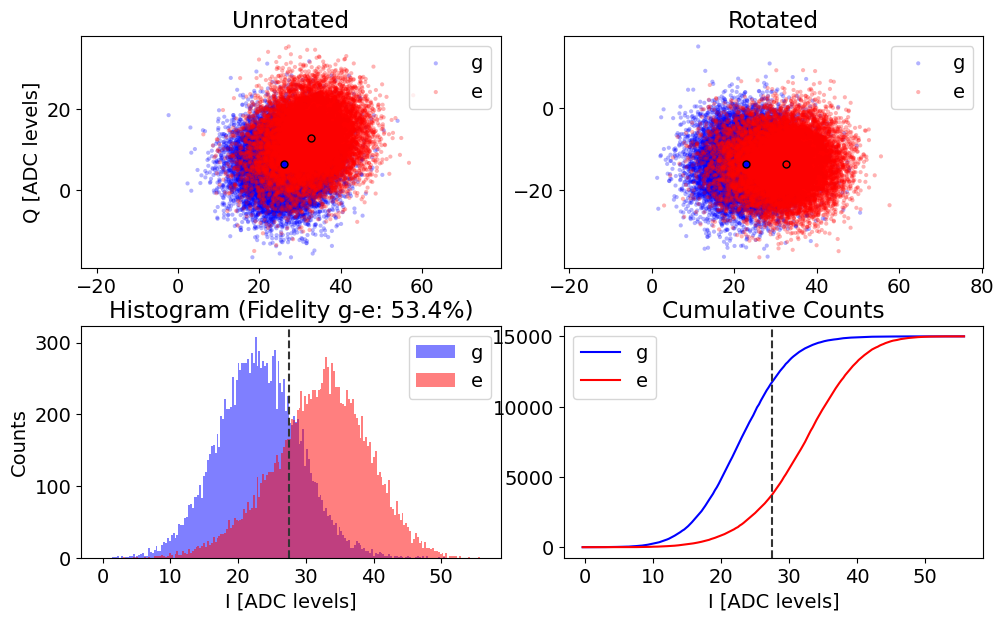

ge fidelity (%): 53.42844761492049 	 angle (deg): -44.34042456253264 	 threshold ge: 27.515125163909044
thresholds=[0, 0, 0, 27.515125163909044],
angles=[0, 0, 0, -44.34042456253264],
ge_avgs=[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), [25.971563849154748, 6.424843693107931, 32.512913047247515, 12.779400953619419]],
counts_calib=[[0, 11589, 0, 3411], [0, 3597, 0, 11403]]


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
npulsecalib = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptQ{qubit_i}",
    config_file=config_path,
)

npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalib.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=2000,
    loops=20,
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    test_pi_half=False,

    post_process=True,
    singleshot_reps=15000,
)

print(npulsecalib.cfg)
import Pyro4.util
try:
    npulsecalib.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

25.971563849154748 32.512913047247515
6.424843693107931 12.779400953619419
26.75445281166465 34.934261170822644
From amps: adjust amplitude to (current gain) / 0.9958423100112715


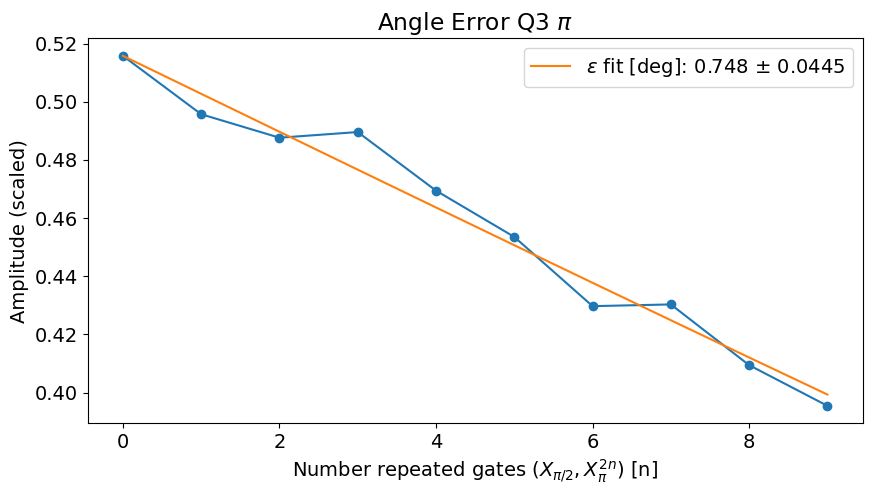

From avgi: adjust amplitude to (current gain) / 0.9958295791421025

From avgq: adjust amplitude to (current gain) / 0.9958422942664888


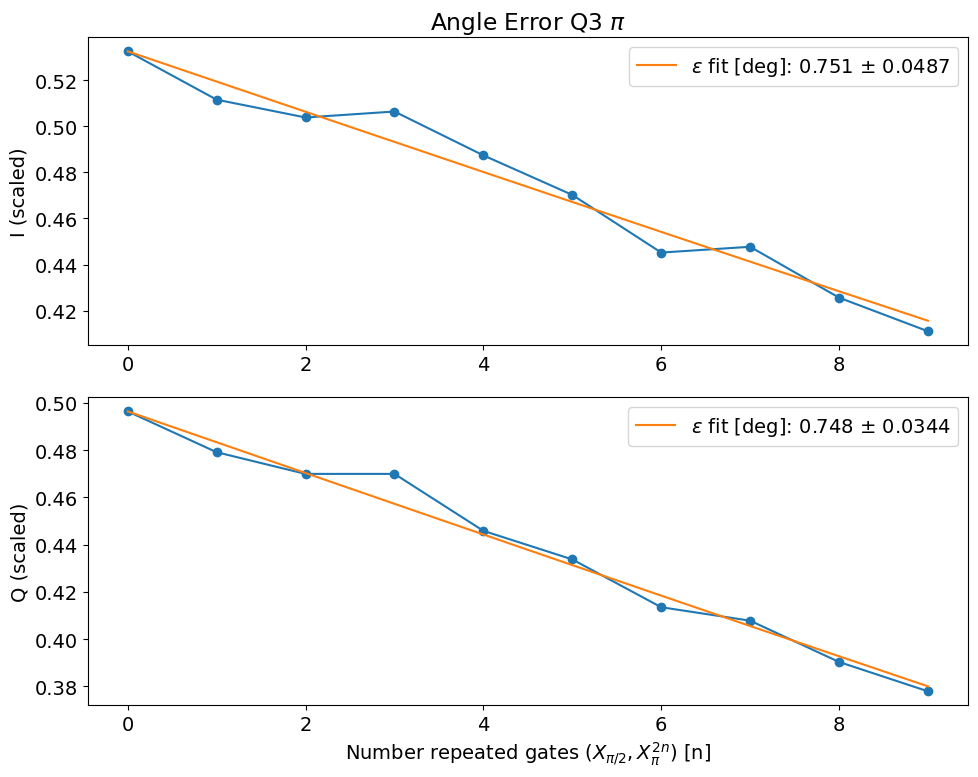

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib.data
npulsecalib.analyze(fit=True, scale=data['ge_avgs'])
npulsecalib.display(fit=True, scale=data['ge_avgs'])

npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data)

angle_err = npulsecalib_fit[1]
amp_ratio = (180 - angle_err) / 180
new_amp_ge = npulsecalib.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(round(new_amp_ge))
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(results_Qi)

In [ ]:
if save_data: npulsecalib.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00001_NPulseExptQ1.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240218\\00001_NPulseExptQ1.h5'

## $T_2$ Ramsey round 3

Run again in case adjust frequency in the wrong direction previously.

In [ ]:
if redo_t2r:
    t2r_3 = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qubit_i}",
        config_file=config_path,
    )
    t2r_3.cfg = AttrDict(deepcopy(yaml_cfg))

    # make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    t2r_3.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us]
        expts=151,
        ramsey_freq=ramsey_freq/2, # [MHz]
        reps=100,
        # reps=10,
        rounds=30,
        checkZZ=False,
        checkEF=False,
        qubits=[qubit_i],
    )
    t2r_3.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
if redo_t2r:
    # # TESTING
    # # t2r_3 = meas.RamseyExperiment(config_file=config_path)
    # temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
    # t2r_3.data = temp_data

    t2r_3.analyze(fit=True)

    t2r_3_fit, t2r_3_fit_err, t2r_3_adjust = meas.fitting.get_best_fit(t2r_3.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

    if not isinstance(t2r_3_fit, (list, np.ndarray)):
        t2r_3.display(fit=True)
        final_qubit_freq = t2r_3.cfg.device.qubit.f_ge + t2r_3_adjust[0]
        if abs(t2r_3_adjust[0]) <= abs(t2r_adjust[0]):
            yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
            print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
            i_best = np.argmin([t2r_fit_err[3][3], t2r_3_fit_err[3][3]])
            results_Qi.update({'T2':[t2r_fit[3], t2r_3_fit[3]][i_best], 'T2 err':np.sqrt([t2r_fit_err[3][3], t2r_3_fit_err[3][3]][i_best])})
            results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
            print(all_results)
        else:
            assert False, 'Something is wrong, please manually fix!'
    else:
        t2r_3.display(fit=False)
        assert False, 'Fit failed, please manually fix!'

In [ ]:
if redo_t2r:
    if save_data: saved_files.append(t2r_3.save_data())

## $T_2$ Echo

In [844]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubit_hwhm = 2
short_T1 = False
# short_T1 = yaml_cfg.device.qubit.T1[qubit_i] < 20
print('Short T1', short_T1)

Short T1 False


In [845]:
ramsey_freq = max((min((np.abs(np.ceil(qubit_hwhm)), 3)), 2))
# ramsey_freq = 1
print(f'Ramsey freq [MHz]: {ramsey_freq}')

Ramsey freq [MHz]: 2.0


In [846]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)
t2e.cfg = AttrDict(deepcopy(yaml_cfg))

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    # step=soc.cycles2us(80), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    step=soc.cycles2us(3) if short_T1 else soc.cycles2us(150), # [us] 
    expts=201,
    ramsey_freq=max((ramsey_freq/15, 0.100)), # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=100,
    # reps=10,
    rounds=20,
    qubit=qubit_i,
)
t2e.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Qubit 3
Current qubit frequency: 4381.086137747587
Fit frequency from I [MHz]: 0.1328891436468871 +/- 0.0005383570942444697
T2 Echo from fit I [us]: 54.10026525264643
Fit frequency from Q [MHz]: 0.13336548908917684 +/- 6.11887240397152e-05
T2 Echo from fit Q [us]: 53.10624420523633


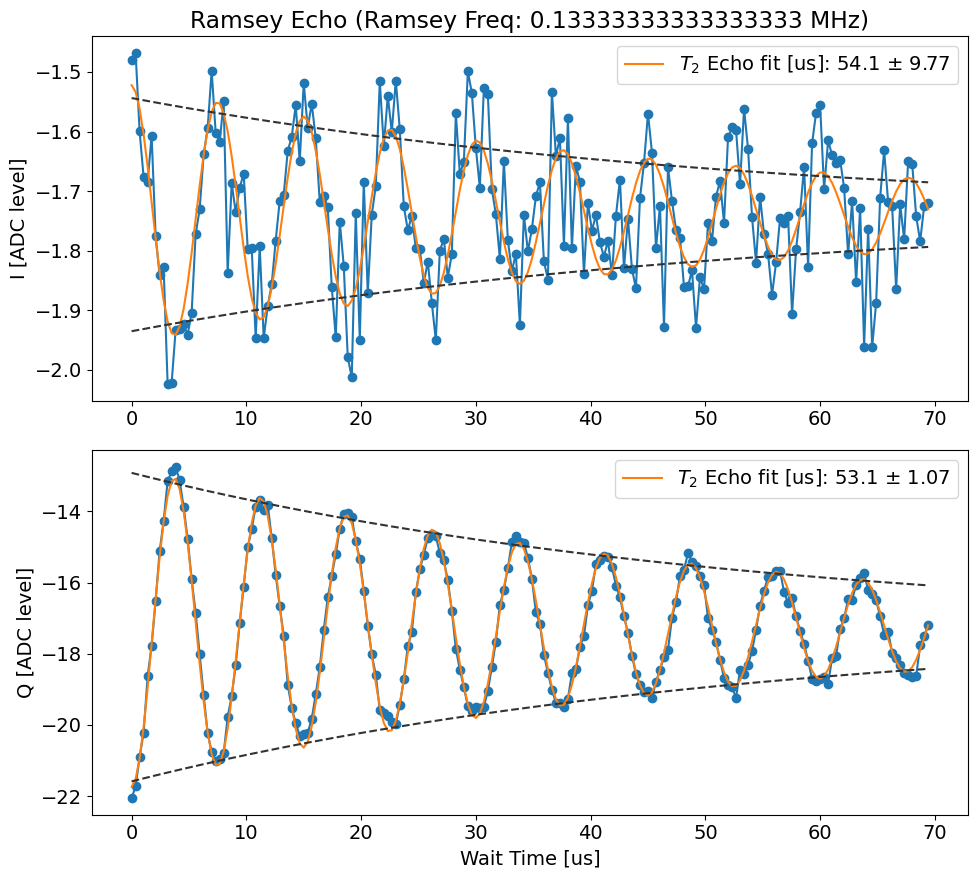

{'Res freq': 6968.517999996667, 'Res kappa': 0.20294457732139853, 'Qubit freq': 4381.086137747587, 'Pi pulse len': 0.01, 'Pi pulse gain': 3845, 'T1': 51.26303063231619, 'T1 err': 0.713440011513084, 'T2R': 24.674137658175617, 'T2R err': 0.8774361671927422, 'T2E': 53.13419215120774, 'T2E err': 1.0664911317281833}


In [847]:
# # TESTING
# # t2e = meas.RamseyEchoExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# t2e.data = temp_data

print(f'Qubit {qubit_i}')
t2e.analyze(fit=True)

t2e_fit, t2e_fit_err = meas.fitting.get_best_fit(t2e.data)

if not isinstance(t2e_fit, (list, np.ndarray)):
    t2e.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2e.display(fit=True)
results_Qi.update({'T2E':t2e_fit[3], 'T2E err':np.sqrt(t2e_fit_err[3][3])})
print(results_Qi)
# print('Results updated.')

In [391]:
if save_data: saved_files.append(t2e.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00000_echo_qubit3.h5


# Resonator chi shift (g/e)

In [848]:
rspec_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspec_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 3 # MHz
npts = 151
rspec_chi.cfg.expt = dict(
    start=rspec_chi.cfg.device.readout.frequency[qubit_i]-span/2, # MHz
    # start=rspec_chi.cfg.device.readout.frequency[qubit_i]-rspec_chi.cfg.device.readout.lo_sideband[qubit_i]*span, # MHz
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspec_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

electrical delay phase correction (no mux support) (deg) 0.11304198470488554
[93.50806622183228, 5000, 1000, 0, 13.935543074483654, 23.078330809881333, -3.478395244069845]
[ 9.26952968e+01  5.05184060e+02  1.82057452e+03  6.57217167e-01
  4.58416231e+01  1.67841674e+01 -3.06806780e+00]
lo freq 5925.0
mux mixer 950
fit resonator freq 92.69529679737919

Freq with minimum transmission: 92.77296688408394
Freq with maximum transmission: 92.07760264567334
From fit:
	f0: 6967.695296797379
	Qi: 505.1840602080371
	Qe: 1820.5745204569068
	Q0: 395.4517187647082
	kappa [MHz]: 17.619585315149745
	phi [radians]: 0.6572171666850332


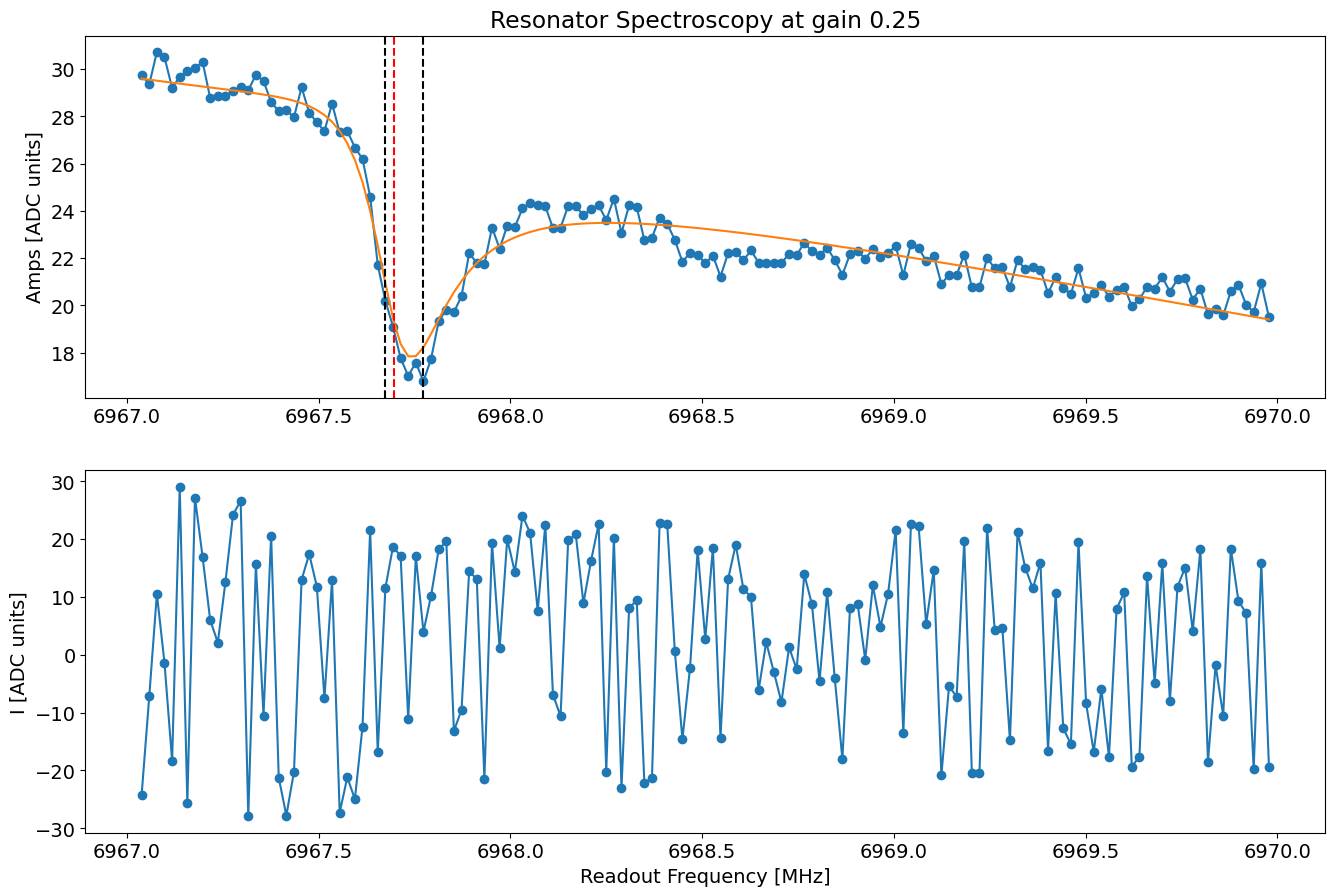

Res freq e 92.77296688408394
Res freq g 93.51799999666672
Chi shift (e-g): -0.7450331125827745
qubit 3 {'Res freq': 6968.517999996667, 'Res kappa': 0.20294457732139853, 'Qubit freq': 4381.086137747587, 'Pi pulse len': 0.01, 'Pi pulse gain': 3845, 'T1': 51.26303063231619, 'T1 err': 0.713440011513084, 'T2R': 24.674137658175617, 'T2R err': 0.8774361671927422, 'T2E': 53.13419215120774, 'T2E err': 1.0664911317281833, 'Res chi shift (e - g)': -0.7450331125827745}


In [849]:
# # TESTING
# # rspec_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec_chi.data = temp_data

rspec_chi.data = rspec_chi.analyze(fit=True)
rspec_chi_fit = rspec_chi.data['fit']
if not isinstance(rspec_chi_fit, (list, np.ndarray)):
    rspec_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec_chi.display(fit=True)
# res_freq_e = rspec_chi_fit[0]
res_freq_e = rspec_chi.data['xpts'][np.argmin(rspec_chi.data['amps'])]
# res_freq_e = rspec_chi.data['xpts'][np.argmax(rspec_chi.data['amps'])]
print('Res freq e', res_freq_e)
print('Res freq g', yaml_cfg.device.readout.frequency[qubit_i])
# res_freq_e = -83
# results_Qi.update({'Res chi shift (e - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - yaml_cfg.device.readout.frequency[qubit_i])})
chi_shift_eg = yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - res_freq_g)
print('Chi shift (e-g):', chi_shift_eg)
results_Qi.update({'Res chi shift (e - g)': chi_shift_eg})
# res_freq_e = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(f'qubit {qubit_i}', results_Qi)

In [394]:
if save_data: saved_files.append(rspec_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00000_resonator_spectroscopy_chi_qubit3.h5


# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

In [850]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 150

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/50), # ef pulse gain
    # gain=5000,
    pulse_type='gauss',
    qubit=qubit_i,
)
qEFspec.cfg.device.readout.relax_delay = qEFspec.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4210.654839068345, HWHM 1.7008310846422452
Found peak in I at [MHz] 4210.646566078878, HWHM 1.6797003667216512
Found peak in Q at [MHz] 4210.667812704573, HWHM 1.7373910934740942


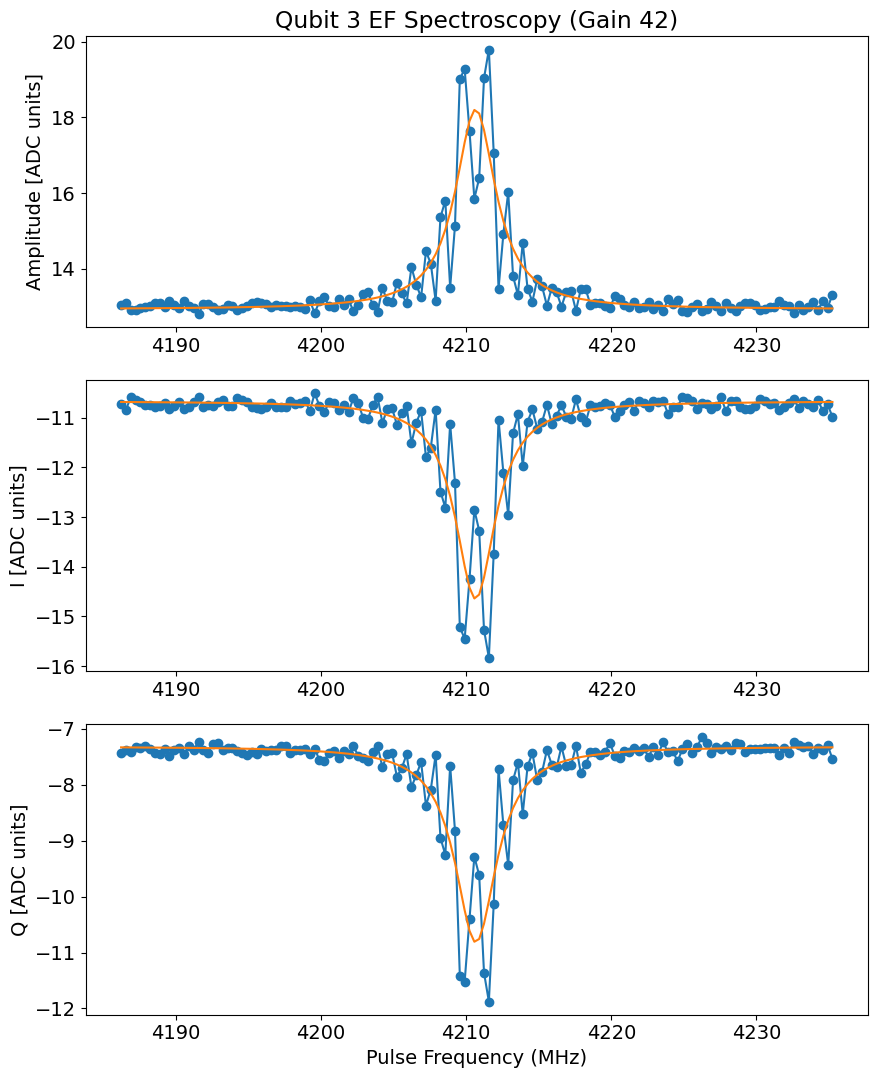

*Set qubit 3 f_ef to 4210.646566078878*
[{}, {'Res freq': 5793.340583232862, 'Res kappa': 0.9819846998794339, 'Qubit freq': 3450.456887958334, 'Pi pulse len': 0.025, 'Pi pulse gain': 22390, 'T1': 85.60426751127089, 'T1 err': 1.9024028748634394, 'T2R': 56.380561904871904, 'T2R err': 2.5555723727435242, 'T2E': 63.973693781650645, 'T2E err': 1.6230346027079428, 'Res chi shift (e - g)': -0.7251655629139577, 'Qubit EF freq': 3349.983151894969, 'EF pi pulse len': 0.02, 'EF pi pulse gain': 20531, 'Qubit temp [mK]': 48.33454624421685}, {'Res freq': 7699.840713915592, 'Res kappa': 0.2127135641654609, 'Qubit freq': 4766.561902541384, 'Pi pulse len': 0.01, 'Pi pulse gain': 11674, 'T1': 45.27317227359091, 'T1 err': 0.6215072956880329, 'T2R': 15.590122767857144, 'T2R err': 0.6253231638116888, 'T2E': 63.52622847609789, 'T2E err': 2.8307801573680593, 'Res chi shift (e - g)': -0.9834437086092294, 'Qubit EF freq': 4576.680453599131, 'EF pi pulse len': 0.012, 'EF pi pulse gain': 6429, 'Qubit temp [mK]':

In [851]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qEFspec.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec.analyze(fit=True, signs=best_signs)
qEFspec.display(fit=True, signs=best_signs)

better_fit = (qEFspec.data['fit_avgi'], qEFspec.data['fit_avgq'])[np.argmin((qEFspec.data['fit_err_avgi'][2][2], qEFspec.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ef[qubit_i] = better_fit[2]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [760]:
if save_data: saved_files.append(qEFspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00002_qubit_EF_spectroscopy_qubit1.h5


## Pulse Probe EF spectroscopy round 2

In [852]:
qEFspec2 = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 20
npts = 150

qEFspec2.cfg.expt = dict(
    start=qEFspec2.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/80), # ef pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qEFspec2.cfg.device.readout.relax_delay = qEFspec2.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4210.6947223859, HWHM 2.326756641904862
Found peak in I at [MHz] 4210.699580095971, HWHM 2.3023777143064397
Found peak in Q at [MHz] 4210.687991254076, HWHM 2.3688770016169376


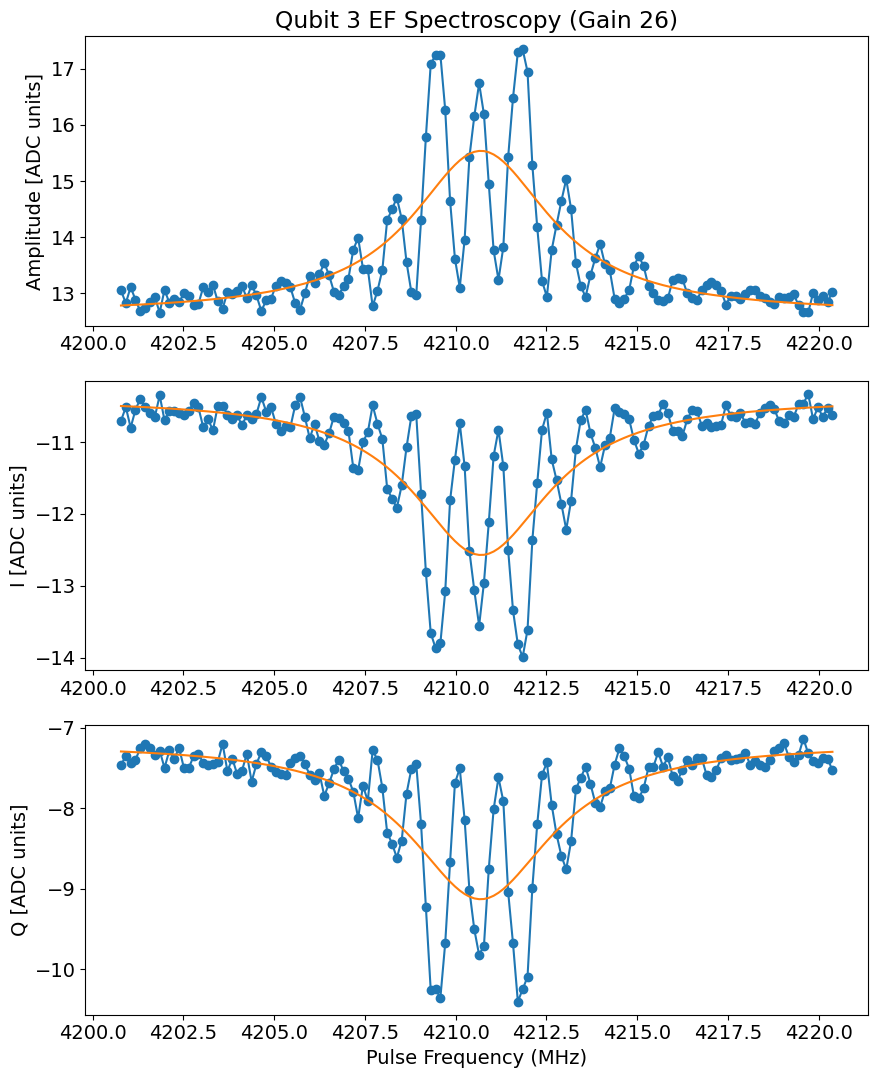

*Set qubit 3 f_ef to 4210.6947223859*
[{}, {'Res freq': 5793.340583232862, 'Res kappa': 0.9819846998794339, 'Qubit freq': 3450.456887958334, 'Pi pulse len': 0.025, 'Pi pulse gain': 22390, 'T1': 85.60426751127089, 'T1 err': 1.9024028748634394, 'T2R': 56.380561904871904, 'T2R err': 2.5555723727435242, 'T2E': 63.973693781650645, 'T2E err': 1.6230346027079428, 'Res chi shift (e - g)': -0.7251655629139577, 'Qubit EF freq': 3349.983151894969, 'EF pi pulse len': 0.02, 'EF pi pulse gain': 20531, 'Qubit temp [mK]': 48.33454624421685}, {'Res freq': 7699.840713915592, 'Res kappa': 0.2127135641654609, 'Qubit freq': 4766.561902541384, 'Pi pulse len': 0.01, 'Pi pulse gain': 11674, 'T1': 45.27317227359091, 'T1 err': 0.6215072956880329, 'T2R': 15.590122767857144, 'T2R err': 0.6253231638116888, 'T2E': 63.52622847609789, 'T2E err': 2.8307801573680593, 'Res chi shift (e - g)': -0.9834437086092294, 'Qubit EF freq': 4576.680453599131, 'EF pi pulse len': 0.012, 'EF pi pulse gain': 6429, 'Qubit temp [mK]': 6

In [853]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec2.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    qEFspec2.analyze(fit=True, signs=[1, sign, sign])
    fit_err_i = qEFspec2.data['fit_err_avgi'][2][2]
    fit_err_q = qEFspec2.data['fit_err_avgq'][2][2]
    if fit_err_i < best_fit_err_i:
        best_signs[1] = sign
        best_fit_err_i = fit_err_i
    if fit_err_q < best_fit_err_q:
        best_signs[2] = sign
        best_fit_err_q = fit_err_q
    # except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec2.analyze(fit=True, signs=best_signs)
qEFspec2.display(fit=True, signs=best_signs)

qEFspec2_fit, qEFspec2_fit_err = meas.fitting.get_best_fit(qEFspec2.data)

yaml_cfg.device.qubit.f_ef[qubit_i] = qEFspec2_fit[2]
qubitEF_hwhm = qEFspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [400]:
if save_data: saved_files.append(qEFspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00001_qubit_EF_spectroscopy_qubit3.h5


## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [66]:
pi_lenEF = yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]
# pi_lenEF = 0.020
print('qubit', qubit_i, 'pi_lenEF', pi_lenEF)

qubit 3 pi_lenEF 0.008


In [67]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]))
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=20,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)

# print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

0.00022217285047767163
0
Pi gain from amps data [dac units]: 3557
	Pi/2 gain from amps data [dac units]: 1778
Pi gain from avgi data [dac units]: 3554
	Pi/2 gain from avgi data [dac units]: 1777
Pi gain from avgq data [dac units]: 3558
	Pi/2 gain from avgq data [dac units]: 1779


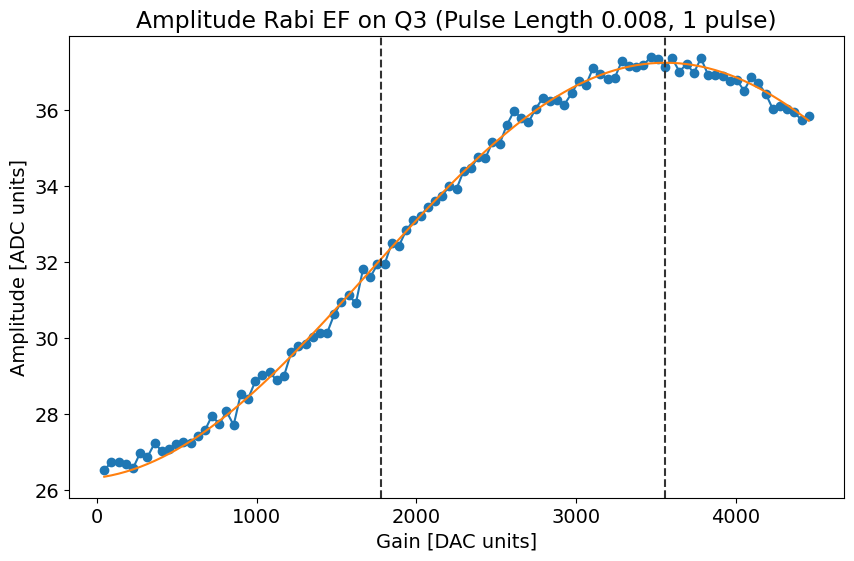

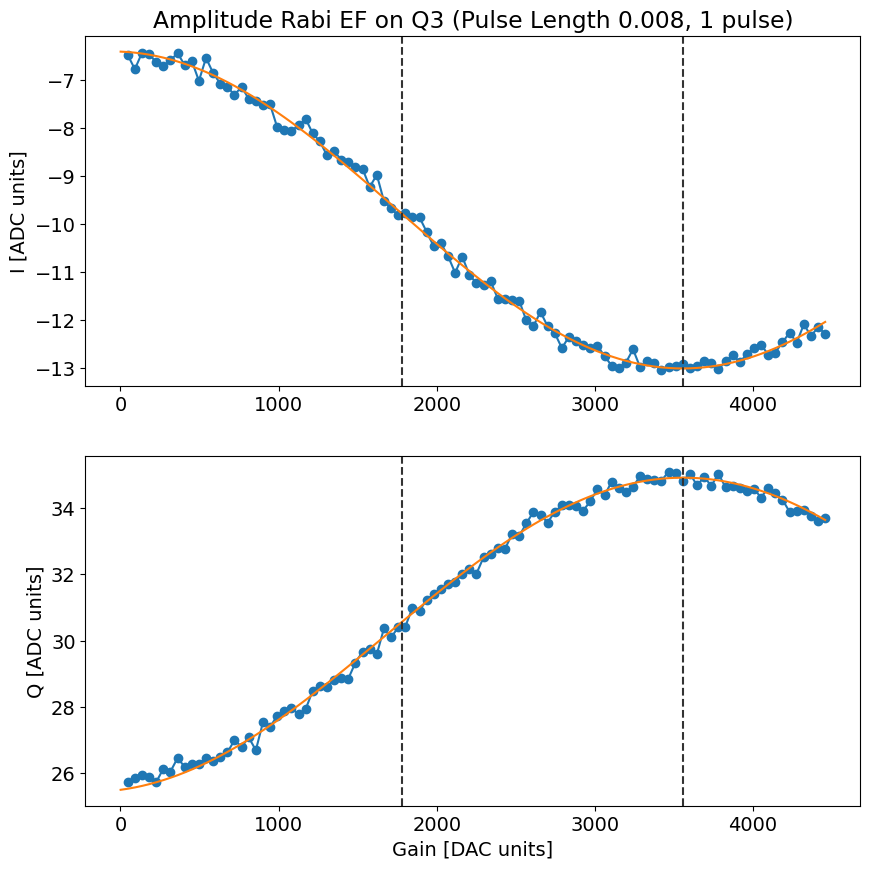

*Set EF pi pulse sigma for qubit 3 to 0.008*
*Set EF pi pulse gain for qubit 3 to 3557*
qubit 3 {'Single shot g-e fidelity (%)': 60.6115152878822, 'Pi pulse gain': 3756.916310025443, 'EF pi pulse gain': 3557, 'EF pi pulse len': 0.008}


In [68]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

# amprabiEF.analyze(fit=False)
# amprabiEF.display(fit=False)

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i] = amprabiEF.cfg.expt.sigma_test
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse len':yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]})
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(f'qubit {qubit_i}', all_results[qubit_i])

In [69]:
if save_data: saved_files.append(amprabiEF.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00003_amp_rabi_EF_qubit3.h5


## Length EF Rabi

In [324]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(3), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=3000,
    gain=yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]//3, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/121 [00:00<?, ?it/s]

Pi length from avgi data [us]: 0.029015676316347768
	Pi/2 length from avgi data [us]: 0.014507838158173884

Pi length from avgq data [us]: 0.03612625578153467
Pi/2 length from avgq data [us]: 0.018063127890767337


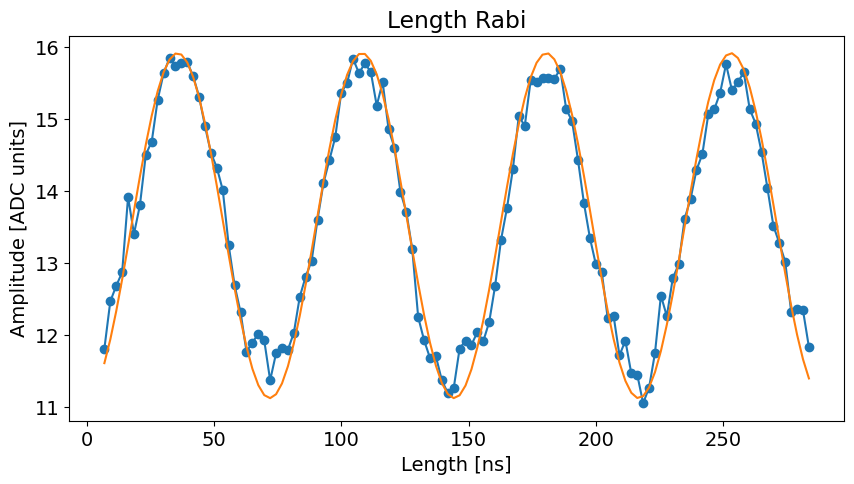

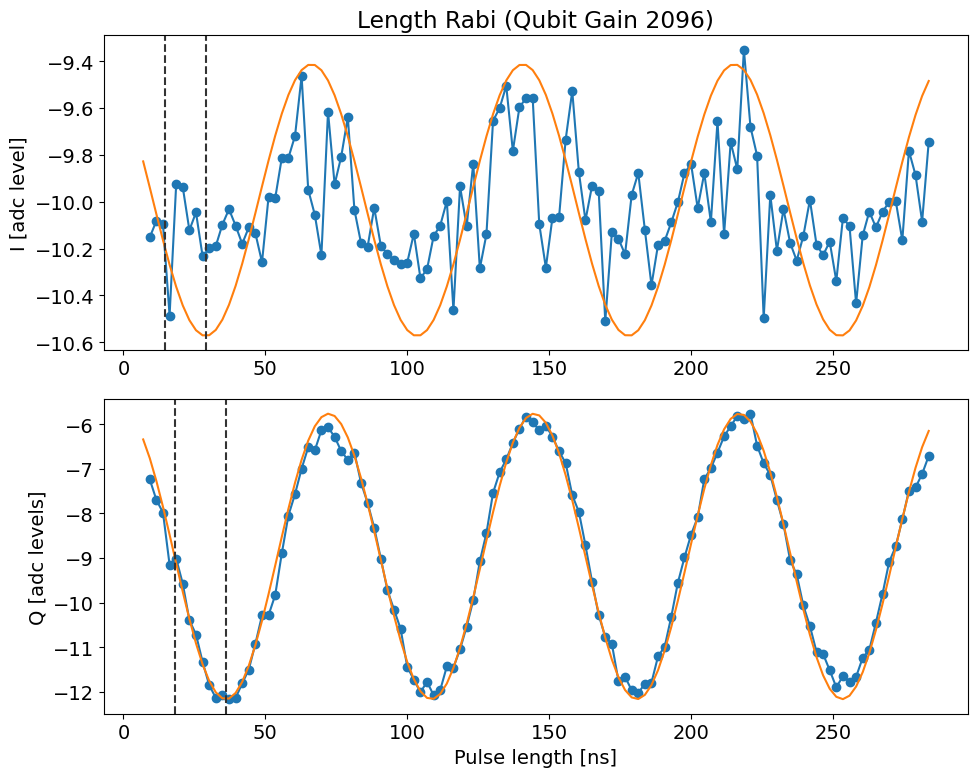

3.200970570012392


In [329]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True, fit_func='sin')

lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=True, fit_func='sin')
p = lengthrabiEF_fit
# if p[2] > 180: p[2] = p[2] - 360
# elif p[2] < -180: p[2] = p[2] + 360
# if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
# else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
# pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

# lengthrabiEF_decay = p[3]

# print(f'Will use sigma {pi_lenEF} for amplitude rabi EF')

In [316]:
if save_data: saved_files.append(lengthrabiEF.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00001_length_rabiEF_qubit3.h5
s:\Connie\experiments\qramLL_4QR2\data\data_240212\00001_length_rabiEF_qubit3.h5


## Qubit temperature

In [857]:
amprabiEF2 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF2.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, 1.25*yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]))
npts = 101

amprabiEF2.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=100,
    sigma_test=pi_lenEF*3, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=False, # set to false when measuring qubit temp
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    # cool_qubits=[1],
    # cool_idle=9.1, # us
    qubits=[qubit_i],
)

# print(amprabiEF2.cfg)
amprabiEF2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 709
	Pi/2 gain from amps data [dac units]: 354
Pi gain from avgi data [dac units]: 703
	Pi/2 gain from avgi data [dac units]: 351
Pi gain from avgq data [dac units]: 719
	Pi/2 gain from avgq data [dac units]: 359


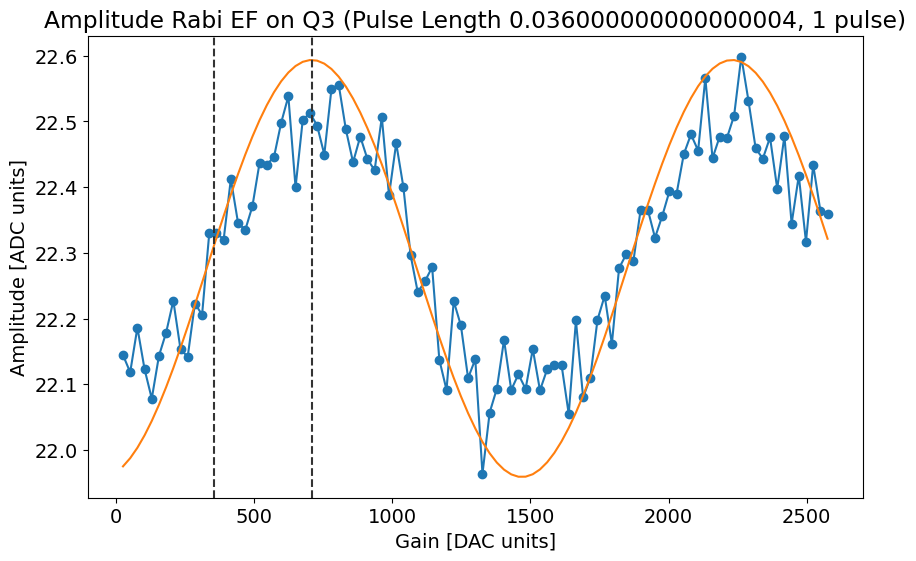

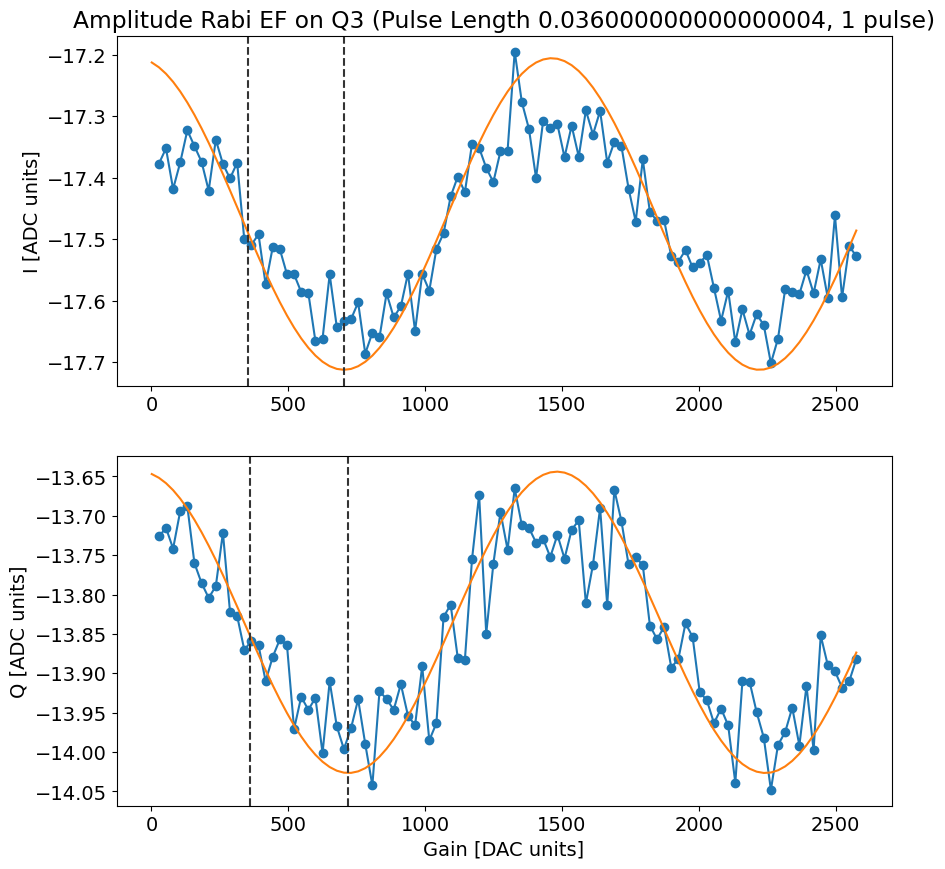

yscale normal: 11.486426572460756
yscale no pulse: 0.3172726574879868
e thermal population: 0.02762152837407787
Qubit temp [mK]: 58.14030017387113
qubit 3
{'Res freq': 6968.517999996667, 'Res kappa': 0.20294457732139853, 'Qubit freq': 4381.086137747587, 'Pi pulse len': 0.01, 'Pi pulse gain': 3845, 'T1': 51.26303063231619, 'T1 err': 0.713440011513084, 'T2R': 24.674137658175617, 'T2R err': 0.8774361671927422, 'T2E': 53.13419215120774, 'T2E err': 1.0664911317281833, 'Res chi shift (e - g)': -0.7450331125827745, 'Qubit EF freq': 4210.6947223859, 'EF pi pulse len': 0.012, 'EF pi pulse gain': 2107, 'Qubit temp [mK]': 58.14030017387113}


In [858]:
# TESTING
# amprabiEF_test = meas.AmplitudeRabiExperiment(config_file=config_path,)
# amprabiEF2 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00004_amp_rabi_EF_qubit1.h5')
# amprabiEF2.data = temp_data

# amprabiEF2.analyze(fit=False)
# amprabiEF2.display(fit=False)

fitparams = [None]*4
fitparams[1] = 2/amprabiEF2.data['xpts'][-1]
amprabiEF2.analyze(fit=True, fitparams=fitparams)

amprabiEF2_fit, amprabiEF2_fit_err = meas.fitting.get_best_fit(amprabiEF2.data)

# NATURAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(amprabiEF2.cfg.device.qubit.f_ge[qubit_i] + amprabiEF2.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################

fit_axis = 'amps'
# fit_axis = 'avgq'

amprabiEF_data = amprabiEF.data[fit_axis]
# amprabiEF2_data = (amprabiEF2.data[fit_axis] + temp_data[fit_axis])/2
p = amprabiEF.data[f'fit_{fit_axis}']
# efamp_normal = p[0]
efamp_normal = max(amprabiEF.data[fit_axis]) - min(amprabiEF.data[fit_axis])

amprabiEF2_data = amprabiEF2.data[fit_axis]
p = amprabiEF2.data[f'fit_{fit_axis}']
efamp_nopulse = p[0]
# fit_vals = meas.fitting.sinfunc(amprabiEF.data['xpts'], *p)
# std_dev_no_pulse = np.std(fit_vals[:10])
# efamp_nopulse = (max(fit_vals) - min(fit_vals))-2*std_dev_no_pulse

amprabiEF2.display(fit=True, fit_func='sin')


print('yscale normal:', efamp_normal)
print('yscale no pulse:', efamp_nopulse)
print('e thermal population:', efamp_nopulse/efamp_normal)

temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/(efamp_normal+efamp_nopulse)))

print('Qubit temp [mK]:', temp)
results_Qi.update({'Qubit temp [mK]':temp})
print(f'qubit {qubit_i}')
print(results_Qi)

In [666]:
if save_data: saved_files.append(amprabiEF2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00007_amp_rabi_EF_qubit2.h5


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [859]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubitEF_hwhm = 2
# short_T1 = False

In [860]:
ramseyEF_freq = max((min((np.abs(np.ceil(qubitEF_hwhm)), 3)), 2))

t2EFr = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=100,
    rounds=15,
    qubits=[qubit_i],
)

import Pyro4.util
try:
    t2EFr.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

readout freq [-67.5604563688476, -818.3405832328616, 824.8407139155917, 93.51799999666672]


  0%|          | 0/15 [00:00<?, ?it/s]

p_amps [ 4.76183026  2.0581497  88.68293811 24.36799367 17.86879548]
ps amps 17.868795475224637 4.761830257324207 24.367993672343815
Current pi pulse frequency: 4210.6947223859
Fit frequency from amps [MHz]: 2.0581497020506845 +/- 0.0009075694718818747
Suggested new pi pulse frequencies from fit amps [MHz]:
 	-0.05814970205068448
 	-4.0581497020506845
T2 Ramsey from fit amps [us]: 24.367993672343815
Current pi pulse frequency: 4210.6947223859
Fit frequency from I [MHz]: 2.0579144404404204 +/- 0.0010073817579406004
Suggested new pi pulse frequency from fit I [MHz]:
 	4210.63680794546
 	4206.63680794546
T2 Ramsey from fit I [us]: 24.720650996194237
Fit frequency from Q [MHz]: 2.058538173962277 +/- 0.0009979366835256064
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4210.636184211938
 	4206.636184211938
T2 Ramsey from fit Q [us]: 23.807779331649357


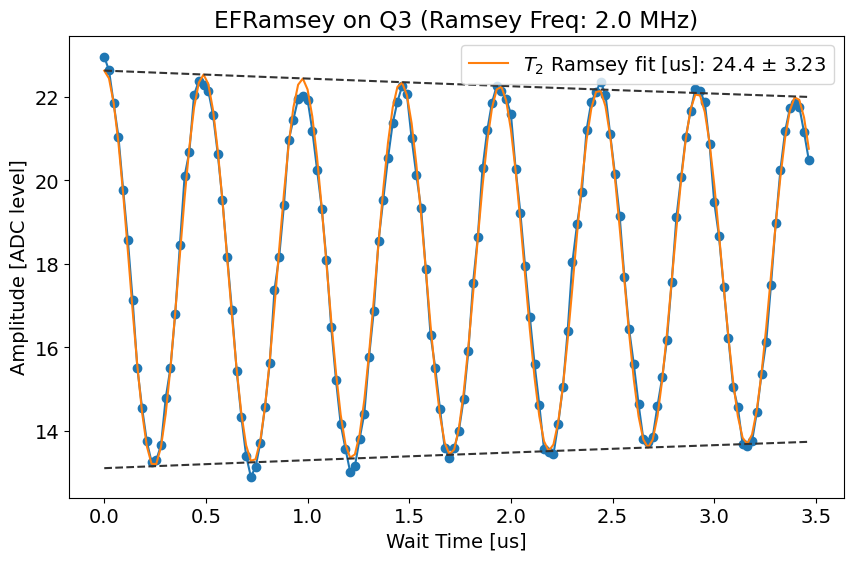

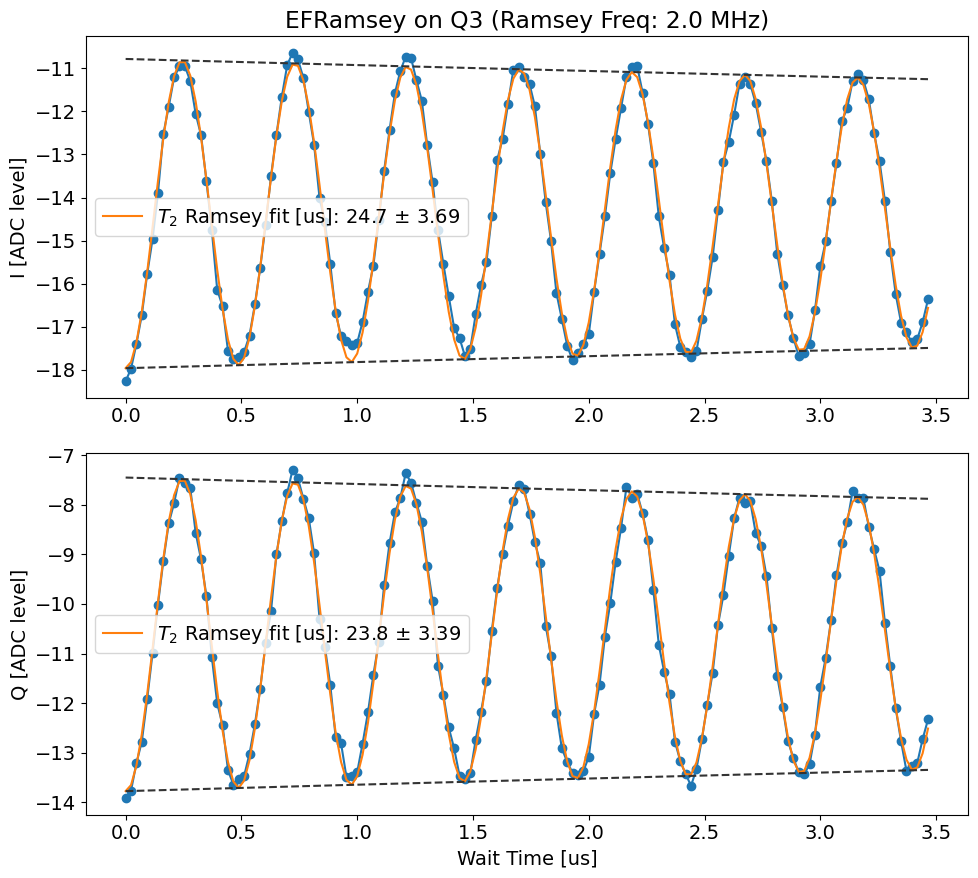

*Set qubit 3 EF freq to 4210.636572683849*
[{}, {'Res freq': 5793.340583232862, 'Res kappa': 0.9819846998794339, 'Qubit freq': 3450.456887958334, 'Pi pulse len': 0.025, 'Pi pulse gain': 22390, 'T1': 85.60426751127089, 'T1 err': 1.9024028748634394, 'T2R': 56.380561904871904, 'T2R err': 2.5555723727435242, 'T2E': 63.973693781650645, 'T2E err': 1.6230346027079428, 'Res chi shift (e - g)': -0.7251655629139577, 'Qubit EF freq': 3349.983151894969, 'EF pi pulse len': 0.02, 'EF pi pulse gain': 20531, 'Qubit temp [mK]': 48.33454624421685}, {'Res freq': 7699.840713915592, 'Res kappa': 0.2127135641654609, 'Qubit freq': 4766.561902541384, 'Pi pulse len': 0.01, 'Pi pulse gain': 11674, 'T1': 45.27317227359091, 'T1 err': 0.6215072956880329, 'T2R': 15.590122767857144, 'T2R err': 0.6253231638116888, 'T2E': 63.52622847609789, 'T2E err': 2.8307801573680593, 'Res chi shift (e - g)': -0.9834437086092294, 'Qubit EF freq': 4576.680453599131, 'EF pi pulse len': 0.012, 'EF pi pulse gain': 6429, 'Qubit temp [mK

In [861]:
# # TESTING
# # t2EFr = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr.data = temp_data

t2EFr.analyze(fit=True)
t2EFr_fit, t2EFr_fit_err, t2EFr_adjust = meas.fitting.get_best_fit(t2EFr.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = t2EFr.cfg.device.qubit.f_ef[qubit_i]

if not isinstance(t2EFr_fit, (list, np.ndarray)):
    t2EFr.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr.display(fit=True)
yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_adjust[0]
alt_qubit_freq = old_qubit_freq + t2EFr_adjust[1]
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [411]:
if save_data: saved_files.append(t2EFr.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00000_ramseyEF_qubit3.h5


## Amplitude EF Rabi round 2

In [862]:
pi_lenEF = yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]
# pi_lenEF = 0.020
print('qubit', qubit_i, 'pi_lenEF', pi_lenEF)

qubit 3 pi_lenEF 0.012


In [863]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

n_pulses = 1
span = min((32000, int(1.5*(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/n_pulses))))
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=20,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    n_pulses=n_pulses,
    qubits=[qubit_i],
)

# print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

0.0003224766204450177
Pi gain from amps data [dac units]: 2108
	Pi/2 gain from amps data [dac units]: 1054
Pi gain from avgi data [dac units]: 2108
	Pi/2 gain from avgi data [dac units]: 1054
Pi gain from avgq data [dac units]: 2107
	Pi/2 gain from avgq data [dac units]: 1053


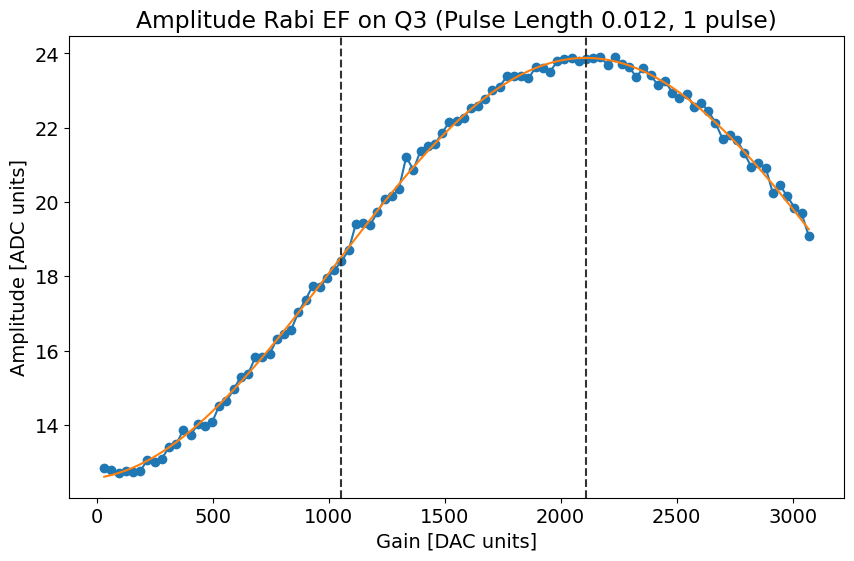

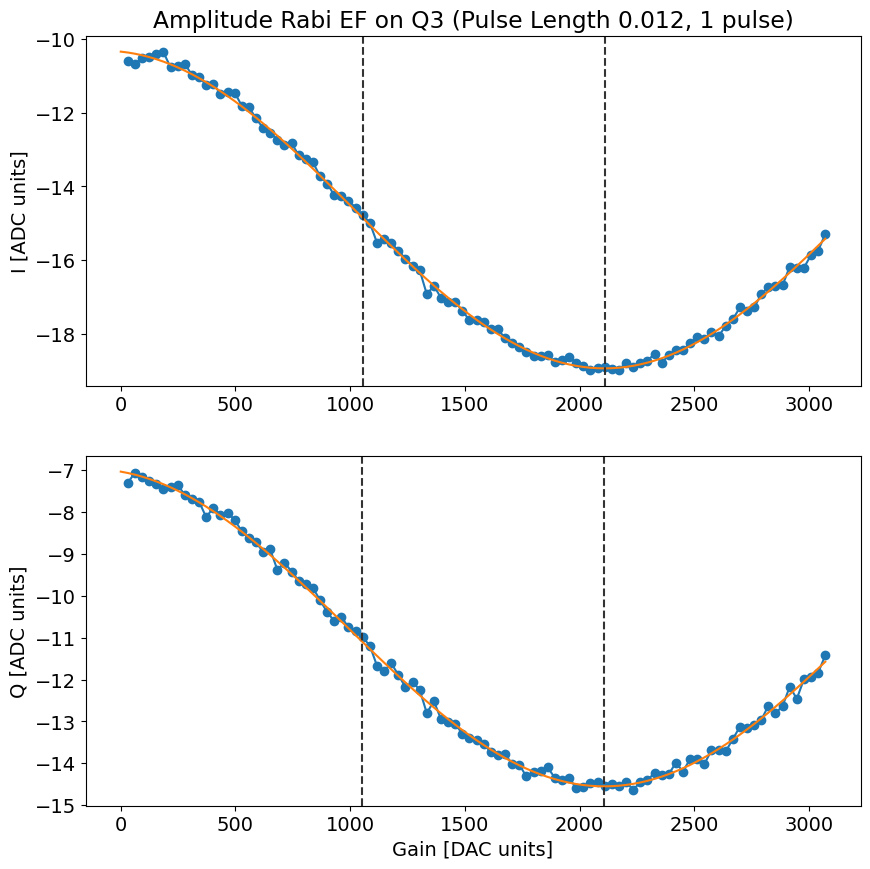

*Set EF pi pulse sigma for qubit 3 to 0.012*
*Set EF pi pulse gain for qubit 3 to 2108*
[{}, {'Res freq': 5793.340583232862, 'Res kappa': 0.9819846998794339, 'Qubit freq': 3450.456887958334, 'Pi pulse len': 0.025, 'Pi pulse gain': 22390, 'T1': 85.60426751127089, 'T1 err': 1.9024028748634394, 'T2R': 56.380561904871904, 'T2R err': 2.5555723727435242, 'T2E': 63.973693781650645, 'T2E err': 1.6230346027079428, 'Res chi shift (e - g)': -0.7251655629139577, 'Qubit EF freq': 3349.983151894969, 'EF pi pulse len': 0.02, 'EF pi pulse gain': 20531, 'Qubit temp [mK]': 48.33454624421685}, {'Res freq': 7699.840713915592, 'Res kappa': 0.2127135641654609, 'Qubit freq': 4766.561902541384, 'Pi pulse len': 0.01, 'Pi pulse gain': 11674, 'T1': 45.27317227359091, 'T1 err': 0.6215072956880329, 'T2R': 15.590122767857144, 'T2R err': 0.6253231638116888, 'T2E': 63.52622847609789, 'T2E err': 2.8307801573680593, 'Res chi shift (e - g)': -0.9834437086092294, 'Qubit EF freq': 4576.680453599131, 'EF pi pulse len': 0.0

In [864]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

# amprabiEF.analyze(fit=False)
# amprabiEF.display(fit=False)

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i] = amprabiEF.cfg.expt.sigma_test
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(pi_gain*n_pulses)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse len':yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]})
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(all_results)

In [415]:
if save_data: saved_files.append(amprabiEF.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00002_amp_rabi_EF_qubit3.h5


## EF Ramsey Fringe Round 2
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [865]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
# qubitEF_hwhm = 7
# short_T1 = False

In [866]:
t2EFr_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr_2.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(80), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq/10, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=100,
    rounds=30,
    qubits=[qubit_i],
)

import Pyro4.util
try:
    t2EFr_2.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

readout freq [-67.5604563688476, -818.3405832328616, 824.8407139155917, 93.51799999666672]


  0%|          | 0/30 [00:00<?, ?it/s]

p_amps [ 5.05084661  0.19359687 99.19786003 15.57924565 18.56862334]
ps amps 18.56862333791617 5.050846605764468 15.57924564603502
Current pi pulse frequency: 4210.636572683849
Fit frequency from amps [MHz]: 0.19359686976509505 +/- 0.00046999318278194793
Suggested new pi pulse frequencies from fit amps [MHz]:
 	0.0064031302349049635
 	-0.39359686976509506
T2 Ramsey from fit amps [us]: 15.57924564603502
Current pi pulse frequency: 4210.636572683849
Fit frequency from I [MHz]: 0.19376203246762683 +/- 0.00043945421214068884
Suggested new pi pulse frequency from fit I [MHz]:
 	4210.642810651382
 	4210.242810651382
T2 Ramsey from fit I [us]: 15.441513435138079
Fit frequency from Q [MHz]: 0.1933464421837851 +/- 0.0005303106133880951
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4210.643226241666
 	4210.243226241666
T2 Ramsey from fit Q [us]: 15.774940721051667


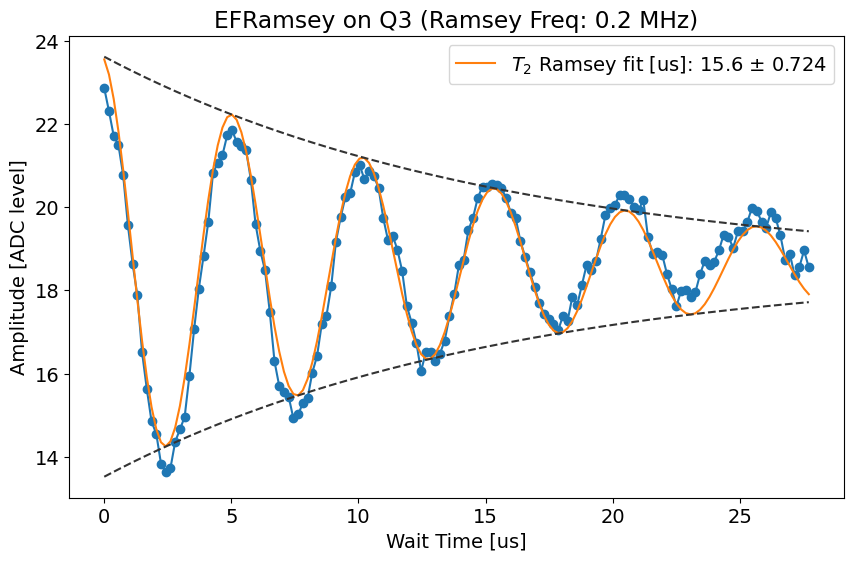

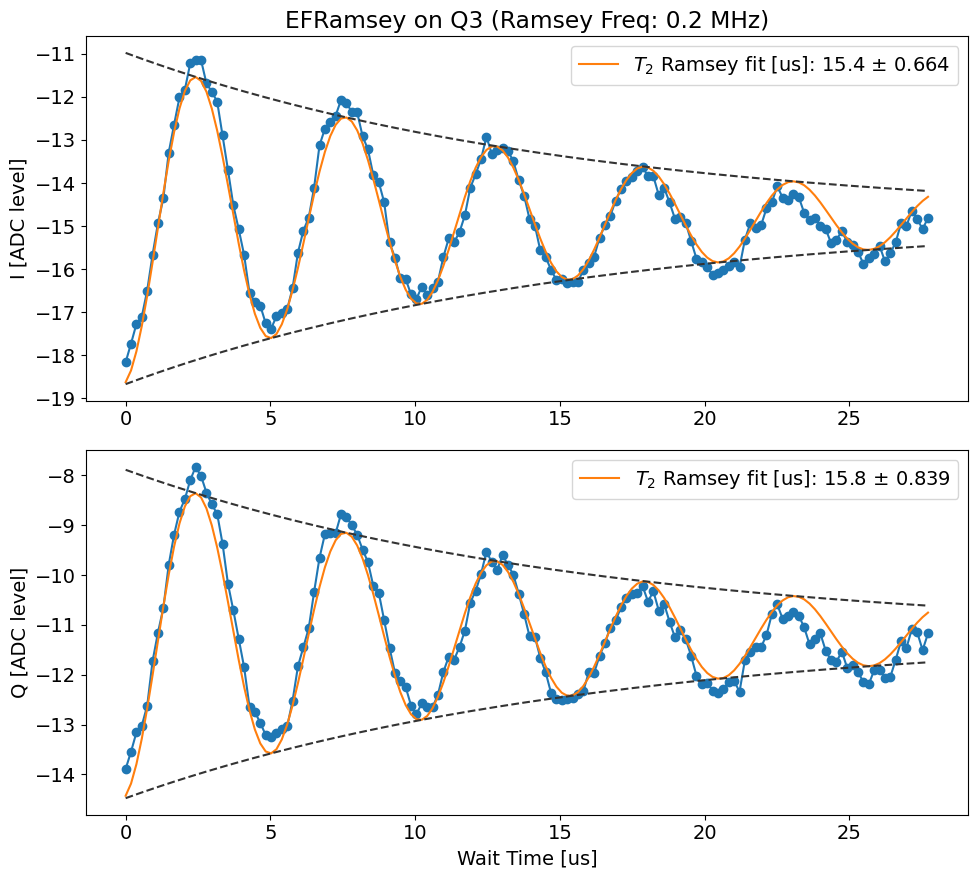

*Set qubit 3 EF freq to 4210.642810651382*
{'Res freq': 6968.517999996667, 'Res kappa': 0.20294457732139853, 'Qubit freq': 4381.086137747587, 'Pi pulse len': 0.01, 'Pi pulse gain': 3845, 'T1': 51.26303063231619, 'T1 err': 0.713440011513084, 'T2R': 24.674137658175617, 'T2R err': 0.8774361671927422, 'T2E': 53.13419215120774, 'T2E err': 1.0664911317281833, 'Res chi shift (e - g)': -0.7450331125827745, 'Qubit EF freq': 4210.642810651382, 'EF pi pulse len': 0.012, 'EF pi pulse gain': 2108, 'Qubit temp [mK]': 58.14030017387113}


In [867]:
# # TESTING
# # t2EFr_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr_2.data = temp_data

t2EFr_2.analyze(fit=True)
t2EFr_2_fit, t2EFr_2_fit_err, t2EFr_2_adjust = meas.fitting.get_best_fit(t2EFr_2.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = t2EFr_2.cfg.device.qubit.f_ef[qubit_i]

if not isinstance(t2EFr_2_fit, (list, np.ndarray)):
    t2EFr_2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr_2.display(fit=True)

if t2EFr_2_adjust[0] > ramseyEF_freq/10:
    print('WARNING: your EF frequency is not converging!')
else:
    yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_2_adjust[0]
    alt_qubit_freq = old_qubit_freq + t2EFr_2_adjust[1]
    print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
    results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(results_Qi)

In [419]:
if save_data: saved_files.append(t2EFr.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00000_ramseyEF_qubit3.h5


## EF error amplification

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671], 'frequency_ef': [-67.5604563688476, -818.3165832328616, 823.0647139155917, 92.22599999666672], 'gain': [0.16, 0.11, 0.3, 0.4], 'readout_length': [7.0, 5.0, 8.0, 2.5], 'relax_delay': [300, 525, 300, 350]}, 'qubit': {'f_ge': [4116.62788350742, 3450.456887958334, 4766.546959121259, 4381.241623620314], 'f_ef': [3890.5466932677664, 3349.983151894969, 4576.680453599131, 4210.642810651382], 'f_Q1_ZZ': [3445.1695202603087, 0, 3449.3409621315604, 3449.179169646872], 'f_Q_ZZ1': [4111.357154037054, 0, 4765.446645017305, 4379.754451085988], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5890.45, 5145.966666666667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [53.81744103399963, 55.95274071800953, 44.5514225071792, 4.324246873301848, 2.3034231276846207, 6.286079155406997], 'ZZs': [0.0, -5.244781107236122, -0.130

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (3)


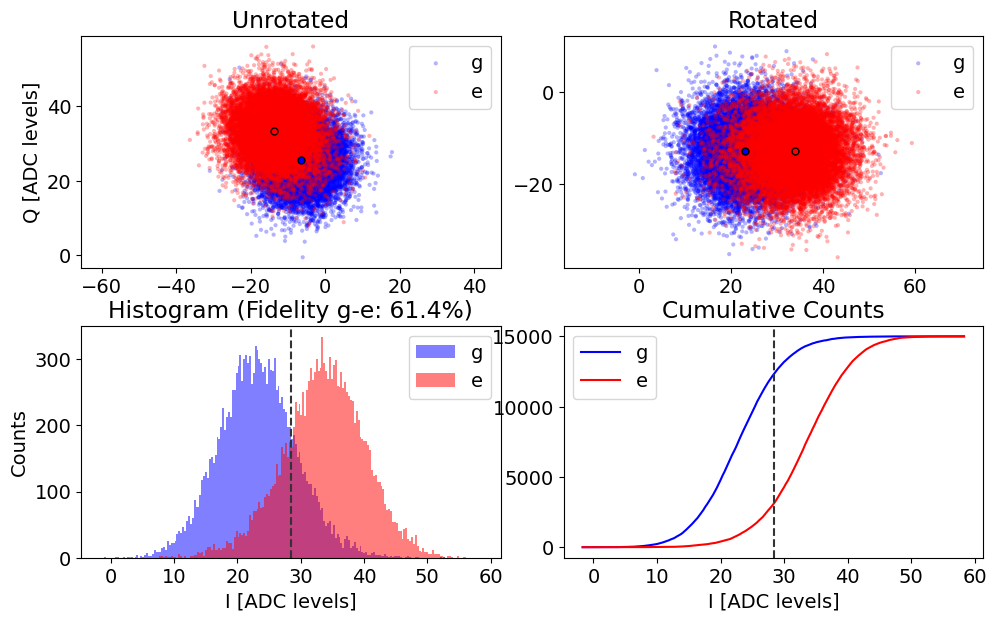

ge fidelity (%): 61.39537984599487 	 angle (deg): -133.11546071569126 	 threshold ge: 28.44412556081507
thresholds=[0, 0, 0, 28.44412556081507],
angles=[0, 0, 0, -133.11546071569126],
ge_avgs=[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), [-6.494564369310794, 25.70454477676636, -13.586340008669268, 33.35465678370178]],
counts_calib=[[9686, 2491, 2250, 573], [2372, 608, 9611, 2409]]


  0%|          | 0/20 [00:00<?, ?it/s]

In [70]:
npulsecalibEF = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptQ{qubit_i}",
    config_file=config_path,
)

npulsecalibEF.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalibEF.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=2000,
    loops=20,
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
    test_pi_half=False,

    post_process=True,
    singleshot_reps=15000,
)

print(npulsecalibEF.cfg)
import Pyro4.util
try:
    npulsecalibEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

From amps: adjust amplitude to (current gain) / 1.0204134767579034


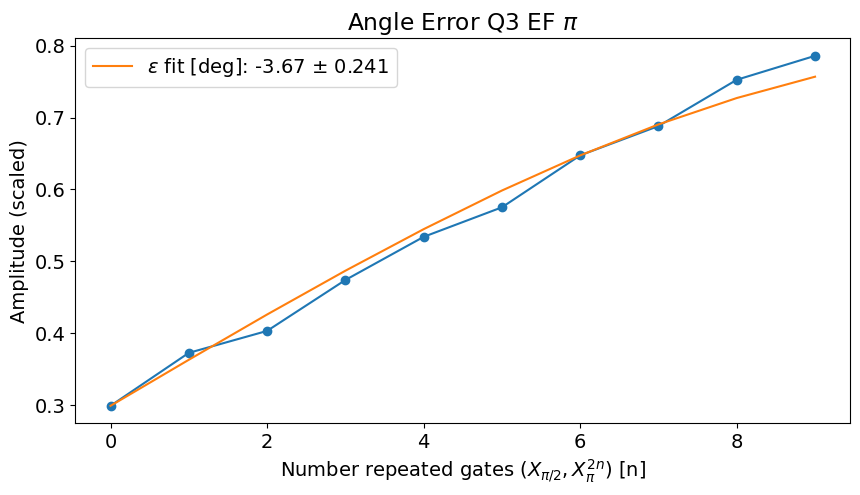

From avgi: adjust amplitude to (current gain) / 1.0165148067474734

From avgq: adjust amplitude to (current gain) / 1.0219511488595385


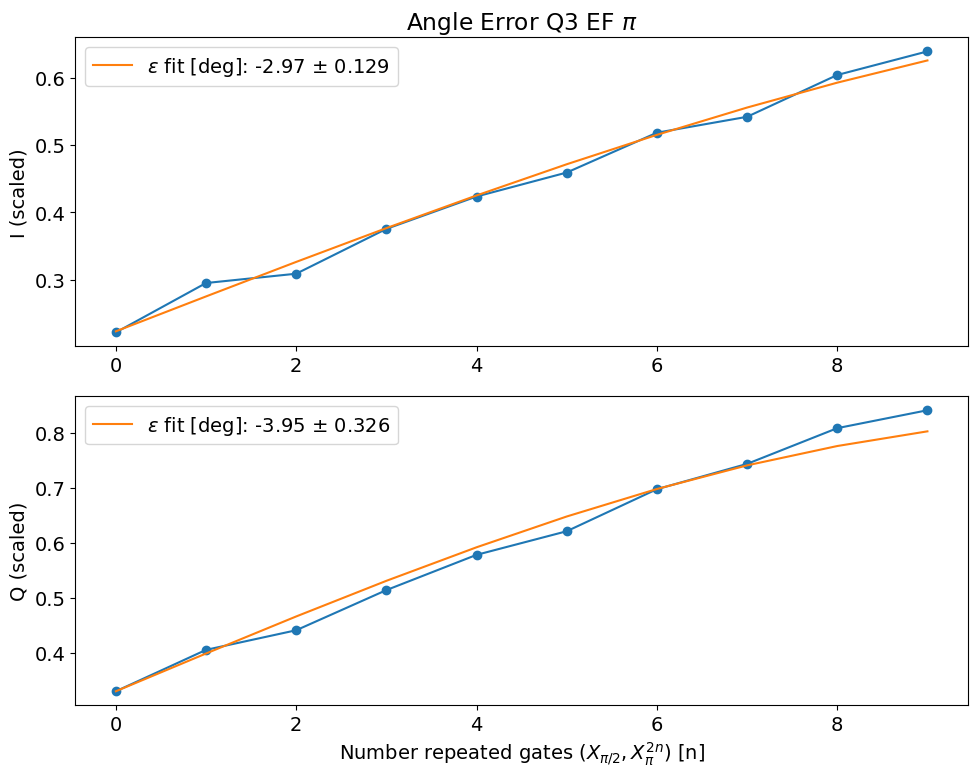

1
*Set pi pulse EF gain for qubit 3 to 3499*
{'Single shot g-e fidelity (%)': 60.6115152878822, 'Pi pulse gain': 3756.916310025443, 'EF pi pulse gain': 3499, 'EF pi pulse len': 0.008}


In [71]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalibEF.data
npulsecalibEF.analyze(fit=True, scale=data['ge_avgs'])
npulsecalibEF.display(fit=True, scale=data['ge_avgs'])

npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalibEF.data)

angle_err = npulsecalib_fit[1]
amp_ratio = (180 - angle_err) / 180
new_amp_ef = npulsecalibEF.cfg.device.qubit.pulses.pi_ef.gain[qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(round(new_amp_ef))
print(f'*Set pi pulse EF gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(results_Qi)

In [72]:
if save_data: npulsecalibEF.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00001_NPulseExptQ3.h5


# Resonator chi shift (e/f)

In [360]:
rspecEF_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspecEF_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspecEF_chi.cfg.expt = dict(
    start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-abs(results_Qi['Res chi shift (e - g)'])-span, # [MHz]
    # start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=True, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspecEF_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspecEF_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[88.34445253529802, 5000, 1000, 0, 17.90881308138134, 128.4870299118777, -3.14927028877128]
[ 8.84455942e+01  2.18252489e+03  4.26021028e+04 -1.25095649e+00
  5.31733600e+01  1.25567845e+02 -3.36161110e+00]
5925.0
950
88.44559421600414

Freq with minimum transmission: 90.76167107834438
Freq with maximum transmission: 86.05968432337748
From fit:
	f0: 6963.445594216004
	Qi: 2182.524893751444
	Qe: 42602.10281203844
	Q0: 2076.1621716330924
	kappa [MHz]: 3.353998878006054
	phi [radians]: -1.2509564861989797


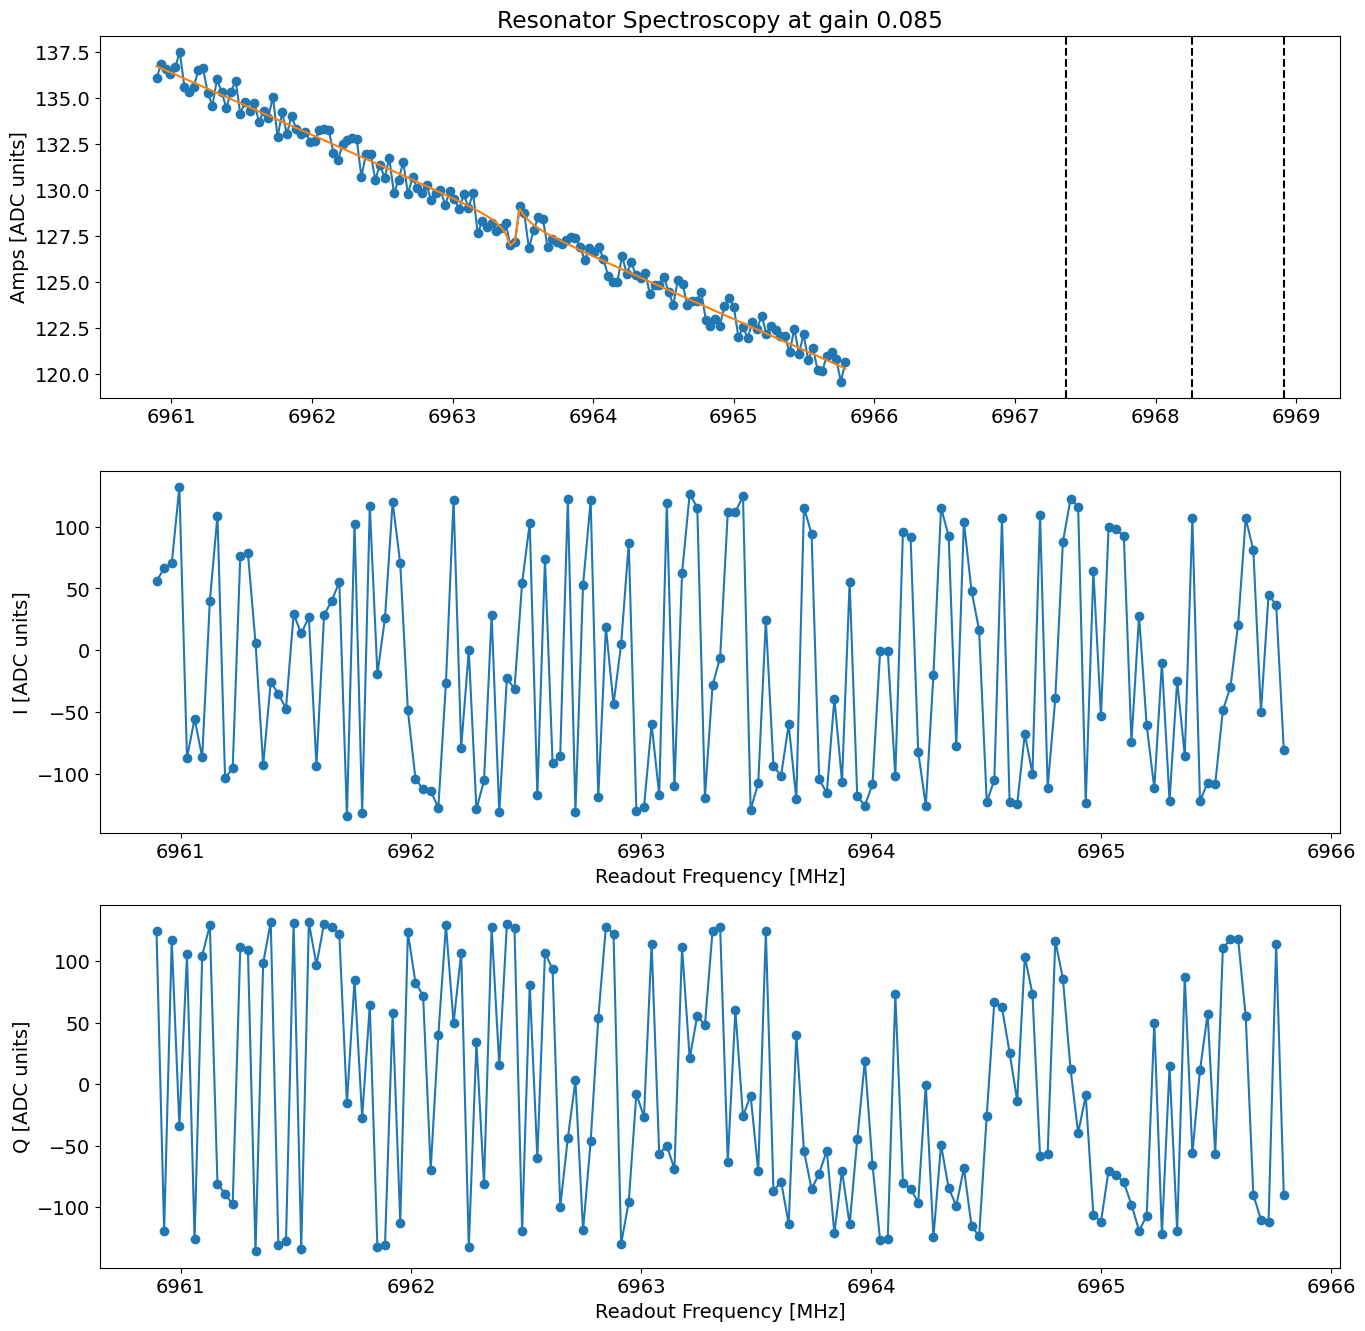

[{'Single shot g-e fidelity (%)': 41.78805960198673}, {'Qubit freq': 3450.7895590725893, 'Pi pulse len': 0.1, 'Pi pulse gain': 24945, 'T1': 88.01528902085553, 'T1 err': 2.3898312185719965, 'T2R': 44.15111045498067, 'T2R err': 1.962086656050886, 'T2E': 30.25929694612411, 'T2E err': 1.7462673977469687, 'Qubit EF freq': 3350.330233073566, 'EF pi pulse len': 0.04686378155276164, 'EF pi pulse gain': 29107, 'Qubit temp [mK]': 56.199674644449665, 'Single shot g-e fidelity (%)': 49.214973832461084}, {'Qubit freq': 4767.359704214145, 'Pi pulse len': 0.020886833661091352, 'Pi pulse gain': 2705, 'T1': 32.93056755583473, 'T1 err': 1.2325694970800454, 'T2R': 12.882410694681475, 'T2R err': 1.4701638837441797, 'T2E': 17.77399784383835, 'T2E err': 0.9103708488638977, 'Res chi shift (e - g)': 1.6390728476820868, 'Qubit EF freq': 4577.689960511519, 'EF pi pulse len': 0.022312951557475664, 'EF pi pulse gain': 1859, 'Qubit temp [mK]': 80.94855045625054, 'Single shot g-e fidelity (%)': 15.340511350378346, 

In [361]:
# # TESTING
# # rspecEF_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspecEF_chi.data = temp_data

rspecEF_chi.analyze(fit=True)
rspecEF_chi_fit = rspecEF_chi.data['fit']
rspecEF_chi.display(fit=True)
# res_freq_f = rspecEF_chi_fit[0]
res_freq_f = rspecEF_chi.data['xpts'][np.argmin(rspecEF_chi.data['amps'])]
results_Qi.update({'Res chi shift (f - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_f = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [362]:
if save_data: saved_files.append(rspecEF_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231127\00001_resonator_spectroscopy_chi_qubit3.h5


# Single Shot

## Single shot optimization

In [576]:
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [28]:
qubit_i = 2

In [593]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

span_f = 1.0*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

# span_f = 2.5*abs(results_Qi['Res kappa']) # MHz
npts_f = 15

span_gain = 0
# npts_gain = 10
# span_gain = 0.08
# npts_gain = 8

# span_len = 8 # us
# npts_len = 2
span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    start_gain=shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2,
    # start_gain=0.05,
    # step_gain=span_gain/npts_gain,
    # expts_gain=npts_gain + 1,
    # start_gain=0.100,
    step_gain=0,
    expts_gain=1,

    start_len=shotopt.cfg.device.readout.readout_length[qubit_i],
    step_len=span_len/npts_len,
    expts_len=npts_len,
    # start_len=2,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.4859999966667], 'gain': [0.16, 0.15, 0.4, 0.25], 'readout_length': [7.0, 5.0, 8.0, 7.0], 'relax_delay': [400, 550, 400, 400]}, 'qubit': {'f_ge': [4117.686452385398, 3450.4061561062, 4767.054343954413, 4383.523802667161], 'f_ef': [3892.010624623449, 3349.941101774378, 4577.031653061257, 4210.841209697969], 'f_Q1_ZZ': [3445.1572577243646, 0, 3449.311443189216, 3449.1061351754615], 'f_Q_ZZ1': [4112.428960914854, 0, 4765.8670233481, 4382.389648653785], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5889.4270833, 5148.666667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [54.18305729787911, 56.80877037961852, 42.812523932608954, 3.2287859260584977, 1.7043533039484866, 5.3832463588099975], 'ZZs': [0.0, -5.260905516769526, -0.09988449936008692, -0.41585925233903254, -5.252491785348866, 0.0, -1.0947129169840082, -1.300020

  0%|          | 0/15 [00:00<?, ?it/s]

freq: 93.4859999966667, gain: 0.25, len: 7.0
	fid ge [%]: 72.26240874695823
freq: 93.49933333000004, gain: 0.25, len: 7.0
	fid ge [%]: 74.04913497116571
freq: 93.51266666333338, gain: 0.25, len: 7.0
	fid ge [%]: 74.97583252775092
freq: 93.52599999666671, gain: 0.25, len: 7.0
	fid ge [%]: 75.51585052835095
freq: 93.53933333000003, gain: 0.25, len: 7.0
	fid ge [%]: 75.39169277951864
freq: 93.55266666333337, gain: 0.25, len: 7.0
	fid ge [%]: 74.78249274975832
freq: 93.5659999966667, gain: 0.25, len: 7.0
	fid ge [%]: 77.00513367557838
freq: 93.57933333000004, gain: 0.25, len: 7.0
	fid ge [%]: 76.69588986299544
freq: 93.59266666333338, gain: 0.25, len: 7.0
	fid ge [%]: 72.01813454230283
freq: 93.60599999666671, gain: 0.25, len: 7.0
	fid ge [%]: 71.34237807926931
freq: 93.61933333000005, gain: 0.25, len: 7.0
	fid ge [%]: 68.94896496549885
freq: 93.63266666333337, gain: 0.25, len: 7.0
	fid ge [%]: 68.075602520084
freq: 93.6459999966667, gain: 0.25, len: 7.0
	fid ge [%]: 66.82222740758024
freq

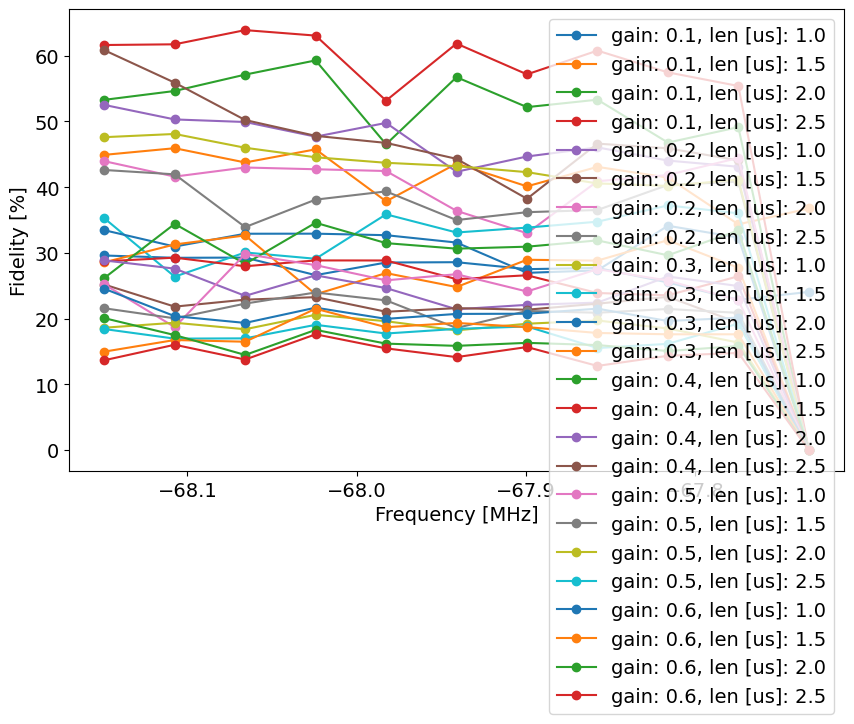

In [102]:

# Using readlines()
file1 = open('C:\\Users\\slab\\Downloads\\singleshot_opt.txt', 'r')
lines = file1.readlines()
freqs = []
gains = []
lengths = []
fids = []

line = lines[0]
words = line.split()
freq = float(words[1][:-1])
freqs.append(freq)
gain = float(words[3][:-1])
gains.append(gain)
length = float(words[5])
lengths.append(length)

fid_line = lines[1]
fids.append(float(fid_line.split()[3]))
 
# Strips the newline character
for i in range(2, len(lines), 2):
    line = lines[i]
    words = line.split()
    freq = float(words[1][:-1])
    if freq not in freqs: freqs.append(freq)
    gain = float(words[3][:-1])
    if gain not in gains: gains.append(gain)
    length = float(words[5])
    if length not in lengths: lengths.append(length)

    fid_line = lines[i+1]
    fids.append(float(fid_line.split()[3]))
    continue

fids = np.append(fids, [0]*22)
fids = np.reshape(fids, newshape=(len(freqs), len(gains), len(lengths)))

# lenpts = [data['lenpts'][0]]
for g_ind, gain in enumerate(gains):
    for l_ind, l in enumerate(lengths):
        plt.plot(freqs, fids[:,g_ind, l_ind], 'o-', label=f'gain: {gain:.2}, len [us]: {l}')
plt.xlabel('Frequency [MHz]')
plt.ylabel(f'Fidelity [%]')
plt.legend()
plt.show()


(6, 0, 0)
[93.486      93.49933333 93.51266666 93.526      93.53933333 93.55266666
 93.566      93.57933333 93.59266666 93.606      93.61933333 93.63266666
 93.646      93.65933333 93.67266666]
[0.25]
[7.]
Max fidelity 77.00513367557838 %
Set params: 
 angle (deg) 146.06527604963216 
 threshold 13.718645346398471 
 freq [Mhz] 93.5659999966667 
 gain [dac units] 0.25 
 readout length [us] 7.0


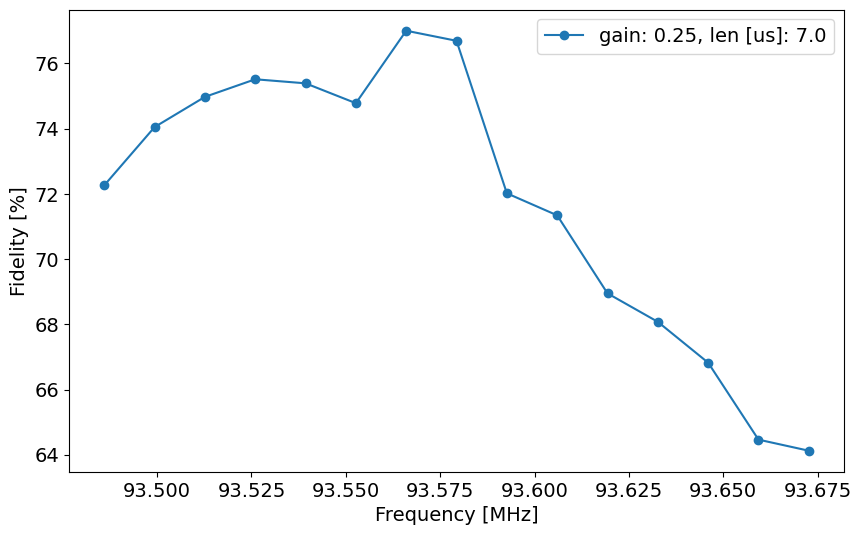

[[[0.72262409]]

 [[0.74049135]]

 [[0.74975833]]

 [[0.75515851]]

 [[0.75391693]]

 [[0.74782493]]

 [[0.77005134]]

 [[0.7669589 ]]

 [[0.72018135]]

 [[0.71342378]]

 [[0.68948965]]

 [[0.68075603]]

 [[0.66822227]]

 [[0.64462149]]

 [[0.64122137]]]


In [594]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [306]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit0.h5


next qubit

In [36]:
qubit_i = 2
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.6
npts_gain = 6

span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.1,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=5,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
    step_len=0,
    expts_len=1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [310]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit3.h5


next qubit

In [41]:
qubit_i = 3
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.1
npts_gain = 8

span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.01,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=8.0,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
    step_len=0,
    expts_len=1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [314]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit1.h5


## Best readout parameters

In [29]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)
shot.cfg = AttrDict(deepcopy(yaml_cfg))

shot.cfg.expt = dict(
    reps=20000,
    check_f=False,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency=freq_opt
# shot.cfg.device.readout.gain[qubit_i]=gain_opt
# print(freq_opt, gain_opt)
# shot.cfg.device.readout.readout_length = len_opt # [us]

# shot.cfg.device.readout.frequency = -816.25952299
shot.cfg.device.readout.gain[qubit_i] = 0.45
shot.cfg.device.readout.readout_length = 2.5

# shot.cfg.device.readout.frequency=-807.4996158081035
# shot.cfg.device.readout.gain[qubit_i]=0.055
# shot.cfg.device.readout.readout_length = 7.0 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671], 'frequency_ef': [-67.5604563688476, -818.3165832328616, 823.0647139155917, 92.22599999666672], 'gain': [0.16, 0.11, 0.4, 0.45], 'readout_length': 2.5, 'relax_delay': [300, 525, 300, 350]}, 'qubit': {'f_ge': [4116.62788350742, 3450.456887958334, 4766.546959121259, 4381.241623620314], 'f_ef': [3890.5466932677664, 3349.983151894969, 4576.680453599131, 4210.642810651382], 'f_Q1_ZZ': [3445.1849181153643, 0, 3449.3659388054953, 3449.167602826072], 'f_Q_ZZ1': [4111.357154037054, 0, 4765.446645017305, 4379.754451085988], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5889.630708333333, 5145.8], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [53.81744103399963, 55.95274071800953, 44.5514225071792, 4.324246873301848, 2.3034231276846207, 6.286079155406997], 'ZZs': [0.0, -5.244781107236122, -0.13017092, -0.5300711

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

Unrotated:
Ig 28.87256176853056 +/- 6.026959567472464 	 Qg 8.2815344603381 +/- 6.043331891775232 	 Amp g 30.0367880455847
Ie 37.43563068920676 +/- 6.571988664931085 	 Qe 14.938231469440833 +/- 6.342435985781355 	 Amp e 40.30604426799127
Rotated:
Ig 27.852863305141625 +/- 6.026959567472464 	 Qg -11.28534112257459 +/- 6.043331891775232 	 Amp g 30.052303048980754
Ie 38.899752183549694 +/- 6.571988664931085 	 Qe -11.138185947794682 +/- 6.342435985781355 	 Amp e 40.46294485265784


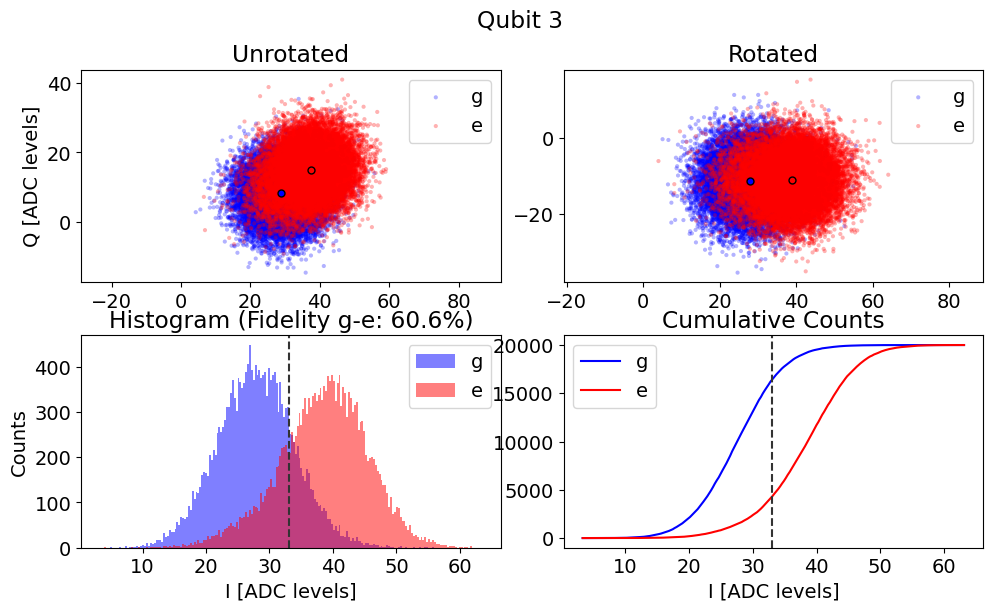

ge fidelity (%): 60.6115152878822
rotation angle (deg): -37.86052384459208
threshold ge: 33.07575916252967


In [30]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)
results_Qi.update({'Single shot g-e fidelity (%)': 100*shot.data['fids'][0]})

In [422]:
if save_data: saved_files.append(shot.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00000_single_shot_qubit3.h5


# Results

In [868]:
print(yaml_cfg)
for Qi, results in enumerate(all_results):
    print(f'Qubit {Qi}')
    for key, value in results.items():
        print(f'\t{key}: {value}')
    print()

for saved_file in saved_files:
    print(saved_file)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.5604563688476, -818.3405832328616, 824.8407139155917, 93.51799999666672], 'frequency_ef': [-67.5604563688476, -818.3165832328616, 823.0647139155917, 92.22599999666672], 'gain': [0.16, 0.11, 0.4, 0.25], 'readout_length': [7.0, 5.0, 8.0, 7.0], 'relax_delay': [300, 342.0, 181.0, 205.0]}, 'qubit': {'f_ge': [4116.60193514429, 3450.456887958334, 4766.561902541384, 4381.086137747587], 'f_ef': [3890.5466932677664, 3349.983151894969, 4576.680453599131, 4210.642810651382], 'f_Q1_ZZ': [3445.2023317296585, 0, 3449.311443189216, 3449.1061351754615], 'f_Q_ZZ1': [4112.401046361381, 0, 4765.8670233481, 4382.389648653785], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5890.497375, 5148.666667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [54.18305729787911, 56.80877037961852, 42.812523932608954, 3.2287859260584977, 1.7043533039484866, 5.3832463588099975], 'ZZs': [0.0, -5.258489224504046,